In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import wandb
import torch.nn.functional as F

In [9]:
def load_dakshina_lexicon_pairs(filepath):
    pairs=[]
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue  # skip empty lines
            parts = line.split('\t')
            if len(parts) != 3:
                continue  # skip malformed lines
            devanagari_word, latin_word,_ = parts
            pairs.append((latin_word, devanagari_word))  # reverse order
    return pairs

In [10]:
def build_vocab(pairs, add_special_tokens=True):
    input_chars = set() # to ensure no repeated characters
    output_chars = set()

    # Collect unique characters from Latin (input) and Devanagari (output)
    for latin_word, devnagari_word in pairs:
        input_chars.update(list(latin_word))
        output_chars.update(list(devnagari_word))

    # Sort to keep it consistent
    input_chars = sorted(list(input_chars))
    output_chars = sorted(list(output_chars))

    # Add special tokens
    special_tokens = ['<pad>', '<sos>', '<eos>', '<unk>'] if add_special_tokens else []

    input_vocab = special_tokens + input_chars
    output_vocab = special_tokens + output_chars

    # Create dictionaries
    input_char2idx = {ch: idx for idx, ch in enumerate(input_vocab)}
    input_idx2char = {idx: ch for ch, idx in input_char2idx.items()}

    output_char2idx = {ch: idx for idx, ch in enumerate(output_vocab)}
    output_idx2char = {idx: ch for ch, idx in output_char2idx.items()}

    return input_char2idx, input_idx2char, output_char2idx, output_idx2char

In [11]:
class Encoder(nn.Module):
    def __init__(self, input_vocab_size, embed_size, hidden_size, num_encoder_layers=1, cell_type='lstm', dropout=0.0):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_encoder_layers = num_encoder_layers
        self.cell_type = cell_type.lower()
        
        # Embedding layer
        self.embedding = nn.Embedding(input_vocab_size, embed_size)
        
        # RNN layer
        if self.cell_type == 'lstm':
            self.rnn = nn.LSTM(
                embed_size, hidden_size, num_encoder_layers,
                batch_first=True, dropout=dropout if num_encoder_layers > 1 else 0
            )
        elif self.cell_type == 'gru':
            self.rnn = nn.GRU(
                embed_size, hidden_size, num_encoder_layers,
                batch_first=True, dropout=dropout if num_encoder_layers > 1 else 0
            )
        else:  # default to RNN
            self.rnn = nn.RNN(
                embed_size, hidden_size, num_encoder_layers,
                batch_first=True, dropout=dropout if num_encoder_layers > 1 else 0
            )
    def forward(self, input_seq, lengths):
        """
        Forward pass for encoder
        
        Args:
            input_seq: Input sequence tensor [batch_size, max_seq_len]
            lengths: Actual lengths of input sequences (tensor)
            
        Returns:
            outputs: Unpacked encoder outputs [batch_size, max_seq_len, hidden_size]
            hidden: Hidden state for decoder initialization
        """
        batch_size = input_seq.size(0)
        
        # Important: ensure lengths is on CPU before using it
        if lengths.is_cuda:
            lengths = lengths.cpu()
        
        # Convert input to embeddings
        embedded = self.embedding(input_seq)  # [batch_size, seq_len, embed_size]
        
        # Pack padded sequence
        packed = nn.utils.rnn.pack_padded_sequence(
            embedded, lengths, batch_first=True, enforce_sorted=False
        )
        
        # Process with RNN
        if self.cell_type == 'lstm':
            packed_outputs, (hidden, cell) = self.rnn(packed)
            outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
            return outputs, (hidden, cell)
        else:
            packed_outputs, hidden = self.rnn(packed)
            outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first=True)
            return outputs, hidden

In [12]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.score = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, decoder_hidden, encoder_outputs):
        # decoder_hidden: [batch_size, hidden_size]
        # encoder_outputs: [batch_size, seq_len, hidden_size]
        seq_len = encoder_outputs.size(1)
        hidden = decoder_hidden.unsqueeze(1).repeat(1, seq_len, 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        scores = self.score(energy).squeeze(2)
        attn_weights = torch.softmax(scores, dim=1)
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs).squeeze(1)
        return context, attn_weights

In [13]:
class Decoder(nn.Module):
    def __init__(self, output_vocab_size, embed_size, hidden_size, num_decoder_layers=1, cell_type='lstm', dropout=0.0):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_decoder_layers = num_decoder_layers
        self.output_vocab_size = output_vocab_size
        self.cell_type = cell_type.lower()

        self.embedding = nn.Embedding(output_vocab_size, embed_size)
        self.attention = Attention(hidden_size)

        self.rnn = nn.LSTM(embed_size + hidden_size, hidden_size, num_decoder_layers,
                           batch_first=True, dropout=dropout if num_decoder_layers > 1 else 0) if self.cell_type == 'lstm' else \
                   nn.GRU(embed_size + hidden_size, hidden_size, num_decoder_layers,
                          batch_first=True, dropout=dropout if num_decoder_layers > 1 else 0)

        self.out = nn.Linear(hidden_size, output_vocab_size)

    def forward(self, input_seq, hidden, encoder_outputs):
        # input_seq: [batch_size, 1]
        embedded = self.embedding(input_seq).squeeze(1)  # [batch_size, embed_size]

        if self.cell_type == 'lstm':
            decoder_hidden = hidden[0][-1]  # last layer's hidden state
        else:
            decoder_hidden = hidden[-1]

        context, attn_weights = self.attention(decoder_hidden, encoder_outputs)  # [batch_size, hidden_size]

        rnn_input = torch.cat((embedded, context), dim=1).unsqueeze(1)  # [batch_size, 1, embed+context]

        if self.cell_type == 'lstm':
            output, (hidden, cell) = self.rnn(rnn_input, hidden)
            output = self.out(output)  # [batch_size, 1, vocab_size]
            return output, (hidden, cell), attn_weights
        else:
            output, hidden = self.rnn(rnn_input, hidden)
            output = self.out(output)  # [batch_size, 1, vocab_size]
            return output, hidden, attn_weights

In [14]:
class TransliterationDataset(Dataset):
    def __init__(self, pairs, input_char2idx, output_char2idx):
        
        '''
        pairs: list of (latin_word, devnagari_word) tuples.
        input_char2idx: dictionary mapping each Latin character to an index.
        output_char2idx: dictionary mapping each Devanagari character to an index.
        '''
            
        self.pairs = pairs
        self.input_char2idx = input_char2idx
        self.output_char2idx = output_char2idx

    # This converts a word into a list of token indices, e.g., India -> [8,13,3,8,0]
    def encode_word(self, word, char2idx, add_sos_eos=False):
        tokens = [char2idx.get(c, char2idx['<unk>']) for c in word]
        if add_sos_eos:
            tokens = [char2idx['<sos>']] + tokens + [char2idx['<eos>']]
        return tokens

    #  Give the total number of latin, devnagri pairs in the dataset
    def __len__(self): 
        return len(self.pairs)

    # This takes the index of the word in latin and gets the latin, devnagri pair. 
        # Then, it converts each word to list of indices and gives the pair of list of indices
    def __getitem__(self, idx):
        latin, devnagari = self.pairs[idx]
        input_ids = self.encode_word(latin, self.input_char2idx)
        target_ids = self.encode_word(devnagari, self.output_char2idx, add_sos_eos=True)
        return input_ids, target_ids

In [15]:
#  Adds pad tokens, given the sequnece, maximum length and pad-token
def pad_seq(seq, max_len, pad_token):
    return seq + [pad_token] * (max_len - len(seq))

def collate_fn(batch):
    '''
    batch: List of tuples [(input1, target1), (input2, target2), ...]

    '''
    input_seqs, target_seqs = zip(*batch)

    input_max_len = max(len(seq) for seq in input_seqs)
    target_max_len = max(len(seq) for seq in target_seqs)

    # Adds padding for seqeuces so that sequence length = maximum sequence length in the batch. 
    # Now all sequenes in the batch are of same length 
    input_padded = [pad_seq(seq, input_max_len, pad_token=input_char2idx['<pad>']) for seq in input_seqs]
    target_padded = [pad_seq(seq, target_max_len, pad_token=output_char2idx['<pad>']) for seq in target_seqs]

    input_tensor = torch.tensor(input_padded, dtype=torch.long)
    target_tensor = torch.tensor(target_padded, dtype=torch.long)

    input_lengths = torch.tensor([len(seq) for seq in input_seqs])
    target_lengths = torch.tensor([len(seq) for seq in target_seqs])

    return input_tensor, input_lengths, target_tensor, target_lengths

In [101]:
sweep_config = {
    'method': 'bayes',  # Could also be 'random' or 'grid'
    'metric': {
        'name': 'token_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'embed_size': {'values': [16, 32, 64]},
        'hidden_size': {'values': [16, 32, 64]},
        'cell_type': {'values': ['RNN', 'GRU', 'LSTM']},
        'dropout': {'values': [0.3, 0.4, 0.5]},
        'batch_size': {'values': [128, 256, 512]},
        'learning_rate': {'values': [5e-3, 1e-3, 5e-4]},
        'beam_size': {'values': [3, 4, 5]}
    },
    'early_terminate': {
        'type': 'hyperband',
        'min_iter': 7
    }
}

In [102]:
import wandb
wandb.login(key="70a00ae1607c730fb9cd50b1268b191bec7a2901")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [16]:
filepath = "/kaggle/input/dakshina-dataset-v1-0/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv"
pairs = load_dakshina_lexicon_pairs(filepath)

input_char2idx, input_idx2char, output_char2idx, output_idx2char = build_vocab(pairs)

print("Latin char2idx:", list(input_char2idx.items())[:5])
print("Devanagari idx2char:", list(output_idx2char.items())[:5])

print(len(list(output_char2idx.keys())))

dataset = TransliterationDataset(pairs, input_char2idx, output_char2idx)

filepath_val = "/kaggle/input/dakshina-dataset-v1-0/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv"
pairs_val = load_dakshina_lexicon_pairs(filepath_val)
dataset_val = TransliterationDataset(pairs_val, input_char2idx, output_char2idx)

Latin char2idx: [('<pad>', 0), ('<sos>', 1), ('<eos>', 2), ('<unk>', 3), ('a', 4)]
Devanagari idx2char: [(0, '<pad>'), (1, '<sos>'), (2, '<eos>'), (3, '<unk>'), (4, 'ँ')]
67


In [104]:
def train():
    wandb.init()
    config = wandb.config
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize encoder and decoder
    encoder = Encoder(
        input_vocab_size=len(input_char2idx),
        embed_size=config.embed_size,
        hidden_size=config.hidden_size,
        num_encoder_layers=1,
        cell_type=config.cell_type,
        dropout=config.dropout
    ).to(device)

    decoder = Decoder(
        output_vocab_size=len(output_char2idx),
        embed_size=config.embed_size,
        hidden_size=config.hidden_size,
        num_decoder_layers=1,
        cell_type=config.cell_type,
        dropout=config.dropout
    ).to(device)

    encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=config.learning_rate, weight_decay=1e-5)
    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=config.learning_rate, weight_decay=1e-5)
    criterion = nn.CrossEntropyLoss(ignore_index=output_char2idx['<pad>'])

    dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True, collate_fn=collate_fn)
    dataloader_val = DataLoader(dataset_val, batch_size=1, shuffle=False, collate_fn=collate_fn)

    num_epochs = 20
    for epoch in range(num_epochs):
        # ======== TRAINING ========
        encoder.train()
        decoder.train()
        total_loss = 0

        with tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
            for input_tensor, input_lengths, target_tensor, target_lengths in pbar:
                input_tensor = input_tensor.to(device)
                target_tensor = target_tensor.to(device)

                encoder_optimizer.zero_grad()
                decoder_optimizer.zero_grad()

                encoder_outputs, encoder_hidden = encoder(input_tensor, input_lengths)
                decoder_input = target_tensor[:, 0].unsqueeze(1)  # <sos>
                decoder_hidden = encoder_hidden

                loss = 0
                max_target_len = target_tensor.size(1)

                for t in range(1, max_target_len):
                    decoder_output, decoder_hidden,_= decoder(decoder_input, decoder_hidden,encoder_outputs)
                    output = decoder_output.squeeze(1)
                    # print(f'output = {output}')
                    # print(f'target tensor = {target_tensor[:,t]}')
                    loss += criterion(output, target_tensor[:, t])
                    decoder_input = target_tensor[:, t].unsqueeze(1)  # Teacher forcing

                loss.backward()
                torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1.0)
                torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=1.0)

                encoder_optimizer.step()
                decoder_optimizer.step()

                total_loss += loss.item() / (max_target_len - 1)

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs} Train Loss: {avg_loss:.4f}")

        # ======== VALIDATION ========
        encoder.eval()
        decoder.eval()
        correct_sequences = 0
        total_sequences = 0
        correct_tokens = 0
        total_tokens = 0
        beam_width = config.beam_size  # You can change this
        
        with torch.no_grad():
            for input_tensor, input_lengths, target_tensor, target_lengths in dataloader_val:
                input_tensor = input_tensor.to(device)
                target_tensor = target_tensor.to(device)
        
                encoder_outputs, encoder_hidden = encoder(input_tensor, input_lengths)
                max_target_len = target_tensor.size(1)
                total_sequences += 1
        
                # Beam is a list of tuples: (sequence_so_far, cumulative_log_prob, decoder_hidden)
                beam = [([output_char2idx['<sos>']], 0.0, encoder_hidden)]
        
                completed_sequences = []
        
                for _ in range(1, max_target_len):
                    new_beam = []
                    for seq, score, hidden in beam:
                        decoder_input = torch.tensor([[seq[-1]]], device=device)
                        decoder_output, hidden_next,_ = decoder(decoder_input, hidden,encoder_outputs)
                        log_probs = F.log_softmax(decoder_output.squeeze(1), dim=1)
        
                        topk_log_probs, topk_indices = log_probs.topk(beam_width)
        
                        for k in range(beam_width):
                            next_token = topk_indices[0][k].item()
                            next_score = score + topk_log_probs[0][k].item()
                            new_seq = seq + [next_token]
                            new_beam.append((new_seq, next_score, hidden_next))
        
                    # Keep top `beam_width` beams with highest scores
                    beam = sorted(new_beam, key=lambda x: x[1], reverse=True)[:beam_width]
        
                    # Move completed sequences out
                    beam, completed = [], []
                    for seq, score, hidden in new_beam:
                        if seq[-1] == output_char2idx['<eos>']:
                            completed_sequences.append((seq, score))
                        else:
                            beam.append((seq, score, hidden))
                    beam = sorted(beam, key=lambda x: x[1], reverse=True)[:beam_width]
        
                # Choose best completed or best incomplete beam
                if completed_sequences:
                    best_seq = max(completed_sequences, key=lambda x: x[1])[0]
                else:
                    best_seq = max(beam, key=lambda x: x[1])[0]
        
                # Remove <sos> if present
                if best_seq[0] == output_char2idx['<sos>']:
                    best_seq = best_seq[1:]
        
                # Compare prediction with target
                target_seq = target_tensor[0, 1:].tolist()
                pad_idx = output_char2idx['<pad>']
        
                # Token accuracy
                for pred_token, tgt_token in zip(best_seq, target_seq):
                    if tgt_token == pad_idx:
                        break
                    if pred_token == tgt_token:
                        correct_tokens += 1
                    total_tokens += 1
        
                # Sequence accuracy
                target_trimmed = [t for t in target_seq if t != pad_idx]
                best_seq_trimmed = best_seq[:len(target_trimmed)]
                if best_seq_trimmed == target_trimmed:
                    correct_sequences += 1
        
                # Optional print
                # predicted_word = indices_to_words([best_seq], output_idx2char)[0]
                # actual_word = indices_to_words([target_trimmed], output_idx2char)[0]
                # # print(f"Predicted: {predicted_word.ljust(20)} | Actual: {actual_word}")
        
        sequence_accuracy = correct_sequences / total_sequences if total_sequences > 0 else 0
        token_accuracy = correct_tokens / total_tokens if total_tokens > 0 else 0
        
        print(f"Token Accuracy: {token_accuracy:.4f}")
        print(f"Sequence Accuracy: {sequence_accuracy:.4f}")
        
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": avg_loss,
            "token_accuracy": token_accuracy,
            "sequence_accuracy": sequence_accuracy
        })

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="DA6401 Assign3 - Attention")
wandb.agent(sweep_id, function=train, count=20)
wandb.finish()

Create sweep with ID: jbseuhp0
Sweep URL: https://wandb.ai/ishita49-indian-institute-of-technology-madras/DA6401%20Assign3%20-%20Attention/sweeps/jbseuhp0


wandb: Agent Starting Run: 51rzlxsd with config:
wandb: 	batch_size: 512
wandb: 	beam_size: 4
wandb: 	cell_type: GRU
wandb: 	dropout: 0.4
wandb: 	embed_size: 16
wandb: 	hidden_size: 16
wandb: 	learning_rate: 0.001


Epoch 1/20: 100%|██████████| 87/87 [00:04<00:00, 18.46it/s]


Epoch 1/20 Train Loss: 3.6399
Token Accuracy: 0.0019
Sequence Accuracy: 0.0000


Epoch 2/20: 100%|██████████| 87/87 [00:04<00:00, 20.98it/s]


Epoch 2/20 Train Loss: 2.7781
Token Accuracy: 0.0510
Sequence Accuracy: 0.0000


Epoch 3/20: 100%|██████████| 87/87 [00:03<00:00, 23.44it/s]


Epoch 3/20 Train Loss: 2.5443
Token Accuracy: 0.0573
Sequence Accuracy: 0.0000


Epoch 4/20: 100%|██████████| 87/87 [00:03<00:00, 22.24it/s]


Epoch 4/20 Train Loss: 2.4011
Token Accuracy: 0.0986
Sequence Accuracy: 0.0000


Epoch 5/20: 100%|██████████| 87/87 [00:03<00:00, 24.23it/s]


Epoch 5/20 Train Loss: 2.3130
Token Accuracy: 0.1150
Sequence Accuracy: 0.0000


Epoch 6/20: 100%|██████████| 87/87 [00:03<00:00, 23.72it/s]


Epoch 6/20 Train Loss: 2.2412
Token Accuracy: 0.1340
Sequence Accuracy: 0.0000


Epoch 7/20: 100%|██████████| 87/87 [00:03<00:00, 23.98it/s]


Epoch 7/20 Train Loss: 2.2057
Token Accuracy: 0.1347
Sequence Accuracy: 0.0000


Epoch 8/20: 100%|██████████| 87/87 [00:03<00:00, 23.45it/s]


Epoch 8/20 Train Loss: 2.1622
Token Accuracy: 0.1359
Sequence Accuracy: 0.0000


Epoch 9/20: 100%|██████████| 87/87 [00:03<00:00, 23.04it/s]


Epoch 9/20 Train Loss: 2.1374
Token Accuracy: 0.1331
Sequence Accuracy: 0.0000


Epoch 10/20: 100%|██████████| 87/87 [00:03<00:00, 24.12it/s]


Epoch 10/20 Train Loss: 2.1138
Token Accuracy: 0.1384
Sequence Accuracy: 0.0000


Epoch 11/20: 100%|██████████| 87/87 [00:03<00:00, 23.63it/s]


Epoch 11/20 Train Loss: 2.0851
Token Accuracy: 0.1379
Sequence Accuracy: 0.0000


Epoch 12/20: 100%|██████████| 87/87 [00:03<00:00, 22.82it/s]


Epoch 12/20 Train Loss: 2.0765
Token Accuracy: 0.1373
Sequence Accuracy: 0.0000


Epoch 13/20: 100%|██████████| 87/87 [00:03<00:00, 23.83it/s]


Epoch 13/20 Train Loss: 2.0467
Token Accuracy: 0.1398
Sequence Accuracy: 0.0000


Epoch 14/20: 100%|██████████| 87/87 [00:03<00:00, 22.90it/s]


Epoch 14/20 Train Loss: 2.0161
Token Accuracy: 0.1378
Sequence Accuracy: 0.0000


Epoch 15/20: 100%|██████████| 87/87 [00:03<00:00, 23.38it/s]


Epoch 15/20 Train Loss: 2.0196
Token Accuracy: 0.1423
Sequence Accuracy: 0.0000


Epoch 16/20: 100%|██████████| 87/87 [00:03<00:00, 23.30it/s]


Epoch 16/20 Train Loss: 1.9785
Token Accuracy: 0.1429
Sequence Accuracy: 0.0000


Epoch 17/20: 100%|██████████| 87/87 [00:03<00:00, 22.37it/s]


Epoch 17/20 Train Loss: 1.9757
Token Accuracy: 0.1514
Sequence Accuracy: 0.0000


Epoch 18/20: 100%|██████████| 87/87 [00:03<00:00, 22.66it/s]


Epoch 18/20 Train Loss: 1.9725
Token Accuracy: 0.1500
Sequence Accuracy: 0.0000


Epoch 19/20: 100%|██████████| 87/87 [00:03<00:00, 22.58it/s]


Epoch 19/20 Train Loss: 1.9696
Token Accuracy: 0.1440
Sequence Accuracy: 0.0000


Epoch 20/20: 100%|██████████| 87/87 [00:03<00:00, 23.69it/s]


Epoch 20/20 Train Loss: 1.9456
Token Accuracy: 0.1501
Sequence Accuracy: 0.0000


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
sequence_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
token_accuracy,▁▃▄▆▆▇▇▇▇▇▇▇▇▇██████
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,20
sequence_accuracy,0
token_accuracy,0.15007
train_loss,1.94556


wandb: Agent Starting Run: zv9eabtl with config:
wandb: 	batch_size: 512
wandb: 	beam_size: 3
wandb: 	cell_type: GRU
wandb: 	dropout: 0.4
wandb: 	embed_size: 32
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.005


Epoch 1/20: 100%|██████████| 87/87 [00:03<00:00, 22.03it/s]


Epoch 1/20 Train Loss: 2.5700
Token Accuracy: 0.1523
Sequence Accuracy: 0.0005


Epoch 2/20: 100%|██████████| 87/87 [00:03<00:00, 23.27it/s]


Epoch 2/20 Train Loss: 1.9020
Token Accuracy: 0.1743
Sequence Accuracy: 0.0000


Epoch 3/20: 100%|██████████| 87/87 [00:03<00:00, 23.45it/s]


Epoch 3/20 Train Loss: 1.6536
Token Accuracy: 0.1976
Sequence Accuracy: 0.0011


Epoch 4/20: 100%|██████████| 87/87 [00:04<00:00, 20.32it/s]


Epoch 4/20 Train Loss: 1.4808
Token Accuracy: 0.2326
Sequence Accuracy: 0.0032


Epoch 5/20: 100%|██████████| 87/87 [00:03<00:00, 22.81it/s]


Epoch 5/20 Train Loss: 1.3875
Token Accuracy: 0.2569
Sequence Accuracy: 0.0060


Epoch 6/20: 100%|██████████| 87/87 [00:03<00:00, 22.82it/s]


Epoch 6/20 Train Loss: 1.2721
Token Accuracy: 0.2607
Sequence Accuracy: 0.0101


Epoch 7/20: 100%|██████████| 87/87 [00:03<00:00, 22.61it/s]


Epoch 7/20 Train Loss: 1.2084
Token Accuracy: 0.3066
Sequence Accuracy: 0.0204


Epoch 8/20: 100%|██████████| 87/87 [00:03<00:00, 22.72it/s]


Epoch 8/20 Train Loss: 1.1029
Token Accuracy: 0.3242
Sequence Accuracy: 0.0275


Epoch 9/20: 100%|██████████| 87/87 [00:04<00:00, 21.04it/s]


Epoch 9/20 Train Loss: 1.0350
Token Accuracy: 0.3687
Sequence Accuracy: 0.0461


Epoch 10/20: 100%|██████████| 87/87 [00:03<00:00, 22.61it/s]


Epoch 10/20 Train Loss: 0.9506
Token Accuracy: 0.3967
Sequence Accuracy: 0.0592


Epoch 11/20: 100%|██████████| 87/87 [00:04<00:00, 21.68it/s]


Epoch 11/20 Train Loss: 0.8838
Token Accuracy: 0.4328
Sequence Accuracy: 0.0773


Epoch 12/20: 100%|██████████| 87/87 [00:03<00:00, 23.35it/s]


Epoch 12/20 Train Loss: 0.8075
Token Accuracy: 0.4677
Sequence Accuracy: 0.0982


Epoch 13/20: 100%|██████████| 87/87 [00:03<00:00, 22.57it/s]


Epoch 13/20 Train Loss: 0.7545
Token Accuracy: 0.5105
Sequence Accuracy: 0.1205


Epoch 14/20: 100%|██████████| 87/87 [00:03<00:00, 22.37it/s]


Epoch 14/20 Train Loss: 0.6948
Token Accuracy: 0.5295
Sequence Accuracy: 0.1329


Epoch 15/20: 100%|██████████| 87/87 [00:03<00:00, 23.74it/s]


Epoch 15/20 Train Loss: 0.6581
Token Accuracy: 0.5315
Sequence Accuracy: 0.1450


Epoch 16/20: 100%|██████████| 87/87 [00:03<00:00, 23.30it/s]


Epoch 16/20 Train Loss: 0.6086
Token Accuracy: 0.5704
Sequence Accuracy: 0.1778


Epoch 17/20: 100%|██████████| 87/87 [00:03<00:00, 23.69it/s]


Epoch 17/20 Train Loss: 0.5788
Token Accuracy: 0.5792
Sequence Accuracy: 0.1870


Epoch 18/20: 100%|██████████| 87/87 [00:03<00:00, 22.10it/s]


Epoch 18/20 Train Loss: 0.5507
Token Accuracy: 0.5900
Sequence Accuracy: 0.2012


Epoch 19/20: 100%|██████████| 87/87 [00:03<00:00, 23.52it/s]


Epoch 19/20 Train Loss: 0.5152
Token Accuracy: 0.6135
Sequence Accuracy: 0.2214


Epoch 20/20: 100%|██████████| 87/87 [00:03<00:00, 23.65it/s]


Epoch 20/20 Train Loss: 0.4963
Token Accuracy: 0.6218
Sequence Accuracy: 0.2230


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
sequence_accuracy,▁▁▁▁▁▁▂▂▂▃▃▄▅▅▆▇▇▇██
token_accuracy,▁▁▂▂▃▃▃▄▄▅▅▆▆▇▇▇▇███
train_loss,█▆▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁
epoch,20
sequence_accuracy,0.22304
token_accuracy,0.62176
train_loss,0.49634


wandb: Agent Starting Run: l3cjx382 with config:
wandb: 	batch_size: 512
wandb: 	beam_size: 4
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.5
wandb: 	embed_size: 32
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.005


Epoch 1/20: 100%|██████████| 87/87 [00:04<00:00, 21.56it/s]


Epoch 1/20 Train Loss: 2.6200
Token Accuracy: 0.1390
Sequence Accuracy: 0.0000


Epoch 2/20: 100%|██████████| 87/87 [00:03<00:00, 22.58it/s]


Epoch 2/20 Train Loss: 1.9260
Token Accuracy: 0.1797
Sequence Accuracy: 0.0000


Epoch 3/20: 100%|██████████| 87/87 [00:04<00:00, 20.52it/s]


Epoch 3/20 Train Loss: 1.6661
Token Accuracy: 0.2153
Sequence Accuracy: 0.0014


Epoch 4/20: 100%|██████████| 87/87 [00:03<00:00, 22.12it/s]


Epoch 4/20 Train Loss: 1.4932
Token Accuracy: 0.2412
Sequence Accuracy: 0.0014


Epoch 5/20: 100%|██████████| 87/87 [00:03<00:00, 22.40it/s]


Epoch 5/20 Train Loss: 1.3230
Token Accuracy: 0.2995
Sequence Accuracy: 0.0158


Epoch 6/20: 100%|██████████| 87/87 [00:03<00:00, 22.85it/s]


Epoch 6/20 Train Loss: 1.1963
Token Accuracy: 0.3321
Sequence Accuracy: 0.0246


Epoch 7/20: 100%|██████████| 87/87 [00:03<00:00, 22.69it/s]


Epoch 7/20 Train Loss: 1.0812
Token Accuracy: 0.3656
Sequence Accuracy: 0.0406


Epoch 8/20: 100%|██████████| 87/87 [00:04<00:00, 20.82it/s]


Epoch 8/20 Train Loss: 0.9735
Token Accuracy: 0.3938
Sequence Accuracy: 0.0500


Epoch 9/20: 100%|██████████| 87/87 [00:03<00:00, 22.46it/s]


Epoch 9/20 Train Loss: 0.9006
Token Accuracy: 0.4415
Sequence Accuracy: 0.0833


Epoch 10/20: 100%|██████████| 87/87 [00:03<00:00, 22.57it/s]


Epoch 10/20 Train Loss: 0.8128
Token Accuracy: 0.4890
Sequence Accuracy: 0.1111


Epoch 11/20: 100%|██████████| 87/87 [00:04<00:00, 21.45it/s]


Epoch 11/20 Train Loss: 0.7282
Token Accuracy: 0.5233
Sequence Accuracy: 0.1365


Epoch 12/20: 100%|██████████| 87/87 [00:03<00:00, 22.44it/s]


Epoch 12/20 Train Loss: 0.6653
Token Accuracy: 0.5658
Sequence Accuracy: 0.1705


Epoch 13/20: 100%|██████████| 87/87 [00:04<00:00, 21.31it/s]


Epoch 13/20 Train Loss: 0.6135
Token Accuracy: 0.5926
Sequence Accuracy: 0.1976


Epoch 14/20: 100%|██████████| 87/87 [00:03<00:00, 22.61it/s]


Epoch 14/20 Train Loss: 0.5689
Token Accuracy: 0.6043
Sequence Accuracy: 0.2129


Epoch 15/20: 100%|██████████| 87/87 [00:03<00:00, 22.66it/s]


Epoch 15/20 Train Loss: 0.5349
Token Accuracy: 0.6223
Sequence Accuracy: 0.2315


Epoch 16/20: 100%|██████████| 87/87 [00:03<00:00, 22.65it/s]


Epoch 16/20 Train Loss: 0.5081
Token Accuracy: 0.6362
Sequence Accuracy: 0.2497


Epoch 17/20: 100%|██████████| 87/87 [00:03<00:00, 22.67it/s]


Epoch 17/20 Train Loss: 0.4814
Token Accuracy: 0.6208
Sequence Accuracy: 0.2441


Epoch 18/20: 100%|██████████| 87/87 [00:04<00:00, 21.33it/s]


Epoch 18/20 Train Loss: 0.4642
Token Accuracy: 0.6529
Sequence Accuracy: 0.2669


Epoch 19/20: 100%|██████████| 87/87 [00:03<00:00, 22.61it/s]


Epoch 19/20 Train Loss: 0.4457
Token Accuracy: 0.6610
Sequence Accuracy: 0.2774


Epoch 20/20: 100%|██████████| 87/87 [00:03<00:00, 22.60it/s]


Epoch 20/20 Train Loss: 0.4294
Token Accuracy: 0.6656
Sequence Accuracy: 0.2866


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
sequence_accuracy,▁▁▁▁▁▂▂▂▃▄▄▅▆▆▇▇▇███
token_accuracy,▁▂▂▂▃▄▄▄▅▆▆▇▇▇▇█▇███
train_loss,█▆▅▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁
epoch,20
sequence_accuracy,0.2866
token_accuracy,0.66563
train_loss,0.42938


wandb: Agent Starting Run: i9ywlq6w with config:
wandb: 	batch_size: 512
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.4
wandb: 	embed_size: 32
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001


Epoch 1/20: 100%|██████████| 87/87 [00:03<00:00, 22.11it/s]


Epoch 1/20 Train Loss: 3.2852
Token Accuracy: 0.0786
Sequence Accuracy: 0.0000


Epoch 2/20: 100%|██████████| 87/87 [00:04<00:00, 21.69it/s]


Epoch 2/20 Train Loss: 2.5320
Token Accuracy: 0.0978
Sequence Accuracy: 0.0000


Epoch 3/20: 100%|██████████| 87/87 [00:04<00:00, 21.31it/s]


Epoch 3/20 Train Loss: 2.3811
Token Accuracy: 0.1165
Sequence Accuracy: 0.0000


Epoch 4/20: 100%|██████████| 87/87 [00:03<00:00, 22.45it/s]


Epoch 4/20 Train Loss: 2.2679
Token Accuracy: 0.1393
Sequence Accuracy: 0.0000


Epoch 5/20: 100%|██████████| 87/87 [00:04<00:00, 21.37it/s]


Epoch 5/20 Train Loss: 2.1608
Token Accuracy: 0.1558
Sequence Accuracy: 0.0000


Epoch 6/20: 100%|██████████| 87/87 [00:03<00:00, 22.39it/s]


Epoch 6/20 Train Loss: 2.0643
Token Accuracy: 0.1543
Sequence Accuracy: 0.0000


Epoch 7/20: 100%|██████████| 87/87 [00:04<00:00, 20.25it/s]


Epoch 7/20 Train Loss: 1.9684
Token Accuracy: 0.1668
Sequence Accuracy: 0.0000


Epoch 8/20: 100%|██████████| 87/87 [00:04<00:00, 20.76it/s]


Epoch 8/20 Train Loss: 1.8889


epoch,▁▂▃▅▆▇█
sequence_accuracy,▁▁▁▁▁▁▁
token_accuracy,▁▃▄▆▇▇█
train_loss,█▄▃▃▂▂▁
epoch,7
sequence_accuracy,0
token_accuracy,0.16685
train_loss,1.9684


wandb: Agent Starting Run: 0sulwwsy with config:
wandb: 	batch_size: 256
wandb: 	beam_size: 4
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.4
wandb: 	embed_size: 16
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.005


Epoch 1/20: 100%|██████████| 173/173 [00:07<00:00, 23.36it/s]


Epoch 1/20 Train Loss: 2.4861
Token Accuracy: 0.1306
Sequence Accuracy: 0.0000


Epoch 2/20: 100%|██████████| 173/173 [00:06<00:00, 24.76it/s]


Epoch 2/20 Train Loss: 1.8851
Token Accuracy: 0.1817
Sequence Accuracy: 0.0002


Epoch 3/20: 100%|██████████| 173/173 [00:07<00:00, 24.29it/s]


Epoch 3/20 Train Loss: 1.6277
Token Accuracy: 0.2214
Sequence Accuracy: 0.0009


Epoch 4/20: 100%|██████████| 173/173 [00:07<00:00, 24.23it/s]


Epoch 4/20 Train Loss: 1.4082
Token Accuracy: 0.2769
Sequence Accuracy: 0.0062


Epoch 5/20: 100%|██████████| 173/173 [00:07<00:00, 24.61it/s]


Epoch 5/20 Train Loss: 1.2295
Token Accuracy: 0.3565
Sequence Accuracy: 0.0250


Epoch 6/20: 100%|██████████| 173/173 [00:07<00:00, 24.65it/s]


Epoch 6/20 Train Loss: 1.0494
Token Accuracy: 0.4149
Sequence Accuracy: 0.0539


Epoch 7/20: 100%|██████████| 173/173 [00:07<00:00, 23.91it/s]


Epoch 7/20 Train Loss: 0.9221
Token Accuracy: 0.4800
Sequence Accuracy: 0.0945


Epoch 8/20: 100%|██████████| 173/173 [00:07<00:00, 24.61it/s]


Epoch 8/20 Train Loss: 0.8109
Token Accuracy: 0.5473
Sequence Accuracy: 0.1469


Epoch 9/20: 100%|██████████| 173/173 [00:07<00:00, 24.54it/s]


Epoch 9/20 Train Loss: 0.7186
Token Accuracy: 0.5864
Sequence Accuracy: 0.1843


Epoch 10/20: 100%|██████████| 173/173 [00:06<00:00, 24.76it/s]


Epoch 10/20 Train Loss: 0.6482
Token Accuracy: 0.6179
Sequence Accuracy: 0.2136


Epoch 11/20: 100%|██████████| 173/173 [00:07<00:00, 24.45it/s]


Epoch 11/20 Train Loss: 0.5894
Token Accuracy: 0.6399
Sequence Accuracy: 0.2347


Epoch 12/20: 100%|██████████| 173/173 [00:07<00:00, 24.60it/s]


Epoch 12/20 Train Loss: 0.5439
Token Accuracy: 0.6570
Sequence Accuracy: 0.2698


Epoch 13/20: 100%|██████████| 173/173 [00:07<00:00, 24.21it/s]


Epoch 13/20 Train Loss: 0.5054
Token Accuracy: 0.6724
Sequence Accuracy: 0.2843


Epoch 14/20: 100%|██████████| 173/173 [00:07<00:00, 24.12it/s]


Epoch 14/20 Train Loss: 0.4761
Token Accuracy: 0.6604
Sequence Accuracy: 0.2825


Epoch 15/20: 100%|██████████| 173/173 [00:07<00:00, 23.58it/s]


Epoch 15/20 Train Loss: 0.4553
Token Accuracy: 0.6747
Sequence Accuracy: 0.3050


Epoch 16/20: 100%|██████████| 173/173 [00:07<00:00, 24.64it/s]


Epoch 16/20 Train Loss: 0.4372
Token Accuracy: 0.6786
Sequence Accuracy: 0.2949


Epoch 17/20: 100%|██████████| 173/173 [00:07<00:00, 22.60it/s]


Epoch 17/20 Train Loss: 0.4193
Token Accuracy: 0.6745
Sequence Accuracy: 0.2942


Epoch 18/20: 100%|██████████| 173/173 [00:07<00:00, 21.71it/s]


Epoch 18/20 Train Loss: 0.4144
Token Accuracy: 0.6827
Sequence Accuracy: 0.3100


Epoch 19/20: 100%|██████████| 173/173 [00:08<00:00, 21.55it/s]


Epoch 19/20 Train Loss: 0.3942
Token Accuracy: 0.6930
Sequence Accuracy: 0.3160


Epoch 20/20: 100%|██████████| 173/173 [00:08<00:00, 21.39it/s]


Epoch 20/20 Train Loss: 0.3829
Token Accuracy: 0.7051
Sequence Accuracy: 0.3373


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
sequence_accuracy,▁▁▁▁▂▂▃▄▅▅▆▇▇▇▇▇▇▇██
token_accuracy,▁▂▂▃▄▄▅▆▇▇▇▇█▇██████
train_loss,█▆▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,20
sequence_accuracy,0.33731
token_accuracy,0.70515
train_loss,0.38291


wandb: Agent Starting Run: 1mp7cpz2 with config:
wandb: 	batch_size: 512
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	dropout: 0.3
wandb: 	embed_size: 32
wandb: 	hidden_size: 16
wandb: 	learning_rate: 0.001


Epoch 1/20: 100%|██████████| 87/87 [00:04<00:00, 19.86it/s]


Epoch 1/20 Train Loss: 3.6768
Token Accuracy: 0.0002
Sequence Accuracy: 0.0000


Epoch 2/20: 100%|██████████| 87/87 [00:03<00:00, 21.83it/s]


Epoch 2/20 Train Loss: 2.8403
Token Accuracy: 0.0033
Sequence Accuracy: 0.0000


Epoch 3/20: 100%|██████████| 87/87 [00:03<00:00, 22.59it/s]


Epoch 3/20 Train Loss: 2.6128
Token Accuracy: 0.0480
Sequence Accuracy: 0.0000


Epoch 4/20: 100%|██████████| 87/87 [00:04<00:00, 21.45it/s]


Epoch 4/20 Train Loss: 2.4538
Token Accuracy: 0.0597
Sequence Accuracy: 0.0000


Epoch 5/20: 100%|██████████| 87/87 [00:03<00:00, 21.83it/s]


Epoch 5/20 Train Loss: 2.3271
Token Accuracy: 0.0726
Sequence Accuracy: 0.0000


Epoch 6/20: 100%|██████████| 87/87 [00:04<00:00, 20.17it/s]


Epoch 6/20 Train Loss: 2.2137
Token Accuracy: 0.0963
Sequence Accuracy: 0.0000


Epoch 7/20: 100%|██████████| 87/87 [00:03<00:00, 22.31it/s]


Epoch 7/20 Train Loss: 2.1396
Token Accuracy: 0.1267
Sequence Accuracy: 0.0000


Epoch 8/20: 100%|██████████| 87/87 [00:03<00:00, 22.31it/s]


Epoch 8/20 Train Loss: 2.0772


epoch,▁▂▃▅▆▇█
sequence_accuracy,▁▁▁▁▁▁▁
token_accuracy,▁▁▄▄▅▆█
train_loss,█▄▃▂▂▁▁
epoch,7
sequence_accuracy,0
token_accuracy,0.12672
train_loss,2.13959


wandb: Agent Starting Run: vy38kun8 with config:
wandb: 	batch_size: 256
wandb: 	beam_size: 3
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	embed_size: 64
wandb: 	hidden_size: 16
wandb: 	learning_rate: 0.005


Epoch 1/20: 100%|██████████| 173/173 [00:07<00:00, 24.26it/s]


Epoch 1/20 Train Loss: 2.5713
Token Accuracy: 0.1241
Sequence Accuracy: 0.0000


Epoch 2/20: 100%|██████████| 173/173 [00:07<00:00, 23.69it/s]


Epoch 2/20 Train Loss: 1.9521
Token Accuracy: 0.1567
Sequence Accuracy: 0.0002


Epoch 3/20: 100%|██████████| 173/173 [00:07<00:00, 23.54it/s]


Epoch 3/20 Train Loss: 1.7460
Token Accuracy: 0.1958
Sequence Accuracy: 0.0014


Epoch 4/20: 100%|██████████| 173/173 [00:07<00:00, 22.96it/s]


Epoch 4/20 Train Loss: 1.6031
Token Accuracy: 0.2129
Sequence Accuracy: 0.0021


Epoch 5/20: 100%|██████████| 173/173 [00:07<00:00, 23.75it/s]


Epoch 5/20 Train Loss: 1.4782
Token Accuracy: 0.2363
Sequence Accuracy: 0.0053


Epoch 6/20: 100%|██████████| 173/173 [00:07<00:00, 23.12it/s]


Epoch 6/20 Train Loss: 1.3844
Token Accuracy: 0.2577
Sequence Accuracy: 0.0096


Epoch 7/20: 100%|██████████| 173/173 [00:07<00:00, 24.27it/s]


Epoch 7/20 Train Loss: 1.3050
Token Accuracy: 0.2680
Sequence Accuracy: 0.0126


Epoch 8/20: 100%|██████████| 173/173 [00:07<00:00, 23.77it/s]


Epoch 8/20 Train Loss: 1.2464


epoch,▁▂▃▅▆▇█
sequence_accuracy,▁▁▂▂▄▆█
token_accuracy,▁▃▄▅▆▇█
train_loss,█▅▃▃▂▁▁
epoch,7
sequence_accuracy,0.01262
token_accuracy,0.26804
train_loss,1.30502


wandb: Agent Starting Run: ks9mro0x with config:
wandb: 	batch_size: 256
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.3
wandb: 	embed_size: 32
wandb: 	hidden_size: 16
wandb: 	learning_rate: 0.001


Epoch 1/20: 100%|██████████| 173/173 [00:07<00:00, 23.12it/s]


Epoch 1/20 Train Loss: 3.2241
Token Accuracy: 0.0384
Sequence Accuracy: 0.0000


Epoch 2/20: 100%|██████████| 173/173 [00:07<00:00, 23.67it/s]


Epoch 2/20 Train Loss: 2.5851
Token Accuracy: 0.0780
Sequence Accuracy: 0.0000


Epoch 3/20: 100%|██████████| 173/173 [00:07<00:00, 22.80it/s]


Epoch 3/20 Train Loss: 2.4457
Token Accuracy: 0.0888
Sequence Accuracy: 0.0000


Epoch 4/20: 100%|██████████| 173/173 [00:07<00:00, 24.15it/s]


Epoch 4/20 Train Loss: 2.3302
Token Accuracy: 0.1091
Sequence Accuracy: 0.0000


Epoch 5/20: 100%|██████████| 173/173 [00:07<00:00, 24.10it/s]


Epoch 5/20 Train Loss: 2.2394
Token Accuracy: 0.1257
Sequence Accuracy: 0.0000


Epoch 6/20: 100%|██████████| 173/173 [00:07<00:00, 24.70it/s]


Epoch 6/20 Train Loss: 2.1574
Token Accuracy: 0.1317
Sequence Accuracy: 0.0000


Epoch 7/20: 100%|██████████| 173/173 [00:06<00:00, 24.78it/s]


Epoch 7/20 Train Loss: 2.1004
Token Accuracy: 0.1485
Sequence Accuracy: 0.0000


Epoch 8/20: 100%|██████████| 173/173 [00:06<00:00, 24.73it/s]


Epoch 8/20 Train Loss: 2.0426


epoch,▁▂▃▅▆▇█
sequence_accuracy,▁▁▁▁▁▁▁
token_accuracy,▁▄▄▅▇▇█
train_loss,█▄▃▂▂▁▁
epoch,7
sequence_accuracy,0
token_accuracy,0.14848
train_loss,2.10036


wandb: Agent Starting Run: lygkohte with config:
wandb: 	batch_size: 512
wandb: 	beam_size: 4
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.5
wandb: 	embed_size: 32
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001


Epoch 1/20: 100%|██████████| 87/87 [00:04<00:00, 21.13it/s]


Epoch 1/20 Train Loss: 3.0432
Token Accuracy: 0.0754
Sequence Accuracy: 0.0000


Epoch 2/20: 100%|██████████| 87/87 [00:03<00:00, 21.76it/s]


Epoch 2/20 Train Loss: 2.4436
Token Accuracy: 0.1106
Sequence Accuracy: 0.0000


Epoch 3/20: 100%|██████████| 87/87 [00:04<00:00, 20.97it/s]


Epoch 3/20 Train Loss: 2.2180
Token Accuracy: 0.1311
Sequence Accuracy: 0.0000


Epoch 4/20: 100%|██████████| 87/87 [00:03<00:00, 21.81it/s]


Epoch 4/20 Train Loss: 2.0326
Token Accuracy: 0.1499
Sequence Accuracy: 0.0000


Epoch 5/20: 100%|██████████| 87/87 [00:03<00:00, 22.14it/s]


Epoch 5/20 Train Loss: 1.8530
Token Accuracy: 0.1760
Sequence Accuracy: 0.0000


Epoch 6/20: 100%|██████████| 87/87 [00:04<00:00, 21.44it/s]


Epoch 6/20 Train Loss: 1.7182
Token Accuracy: 0.1998
Sequence Accuracy: 0.0005


Epoch 7/20: 100%|██████████| 87/87 [00:03<00:00, 21.82it/s]


Epoch 7/20 Train Loss: 1.5962
Token Accuracy: 0.2118
Sequence Accuracy: 0.0011


Epoch 8/20: 100%|██████████| 87/87 [00:04<00:00, 21.15it/s]


Epoch 8/20 Train Loss: 1.4978


epoch,▁▂▃▅▆▇█
sequence_accuracy,▁▁▁▁▁▄█
token_accuracy,▁▃▄▅▆▇█
train_loss,█▅▄▃▂▂▁
epoch,7
sequence_accuracy,0.00115
token_accuracy,0.21178
train_loss,1.59615


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8nwufcua with config:
wandb: 	batch_size: 256
wandb: 	beam_size: 5
wandb: 	cell_type: RNN
wandb: 	dropout: 0.4
wandb: 	embed_size: 16
wandb: 	hidden_size: 16
wandb: 	learning_rate: 0.0005


Epoch 1/20: 100%|██████████| 173/173 [00:06<00:00, 25.13it/s]


Epoch 1/20 Train Loss: 3.4162
Token Accuracy: 0.0000
Sequence Accuracy: 0.0000


Epoch 2/20: 100%|██████████| 173/173 [00:06<00:00, 25.17it/s]


Epoch 2/20 Train Loss: 2.8231
Token Accuracy: 0.0340
Sequence Accuracy: 0.0000


Epoch 3/20: 100%|██████████| 173/173 [00:06<00:00, 25.16it/s]


Epoch 3/20 Train Loss: 2.6866
Token Accuracy: 0.0721
Sequence Accuracy: 0.0000


Epoch 4/20: 100%|██████████| 173/173 [00:06<00:00, 25.29it/s]


Epoch 4/20 Train Loss: 2.5502
Token Accuracy: 0.0999
Sequence Accuracy: 0.0000


Epoch 5/20: 100%|██████████| 173/173 [00:07<00:00, 24.67it/s]


Epoch 5/20 Train Loss: 2.4605
Token Accuracy: 0.1010
Sequence Accuracy: 0.0000


Epoch 6/20: 100%|██████████| 173/173 [00:07<00:00, 24.55it/s]


Epoch 6/20 Train Loss: 2.3948
Token Accuracy: 0.0915
Sequence Accuracy: 0.0000


Epoch 7/20: 100%|██████████| 173/173 [00:06<00:00, 25.20it/s]


Epoch 7/20 Train Loss: 2.3529
Token Accuracy: 0.0910
Sequence Accuracy: 0.0000


Epoch 8/20: 100%|██████████| 173/173 [00:06<00:00, 25.04it/s]


Epoch 8/20 Train Loss: 2.3013


epoch,▁▂▃▅▆▇█
sequence_accuracy,▁▁▁▁▁▁▁
token_accuracy,▁▃▆██▇▇
train_loss,█▄▃▂▂▁▁
epoch,7
sequence_accuracy,0
token_accuracy,0.091
train_loss,2.3529


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mhloxpba with config:
wandb: 	batch_size: 128
wandb: 	beam_size: 5
wandb: 	cell_type: GRU
wandb: 	dropout: 0.4
wandb: 	embed_size: 64
wandb: 	hidden_size: 16
wandb: 	learning_rate: 0.005


Epoch 1/20: 100%|██████████| 346/346 [00:12<00:00, 26.89it/s]


Epoch 1/20 Train Loss: 2.3671
Token Accuracy: 0.1568
Sequence Accuracy: 0.0002


Epoch 2/20: 100%|██████████| 346/346 [00:12<00:00, 27.35it/s]


Epoch 2/20 Train Loss: 1.9291
Token Accuracy: 0.1693
Sequence Accuracy: 0.0009


Epoch 3/20: 100%|██████████| 346/346 [00:12<00:00, 27.54it/s]


Epoch 3/20 Train Loss: 1.7611
Token Accuracy: 0.1725
Sequence Accuracy: 0.0005


Epoch 4/20: 100%|██████████| 346/346 [00:12<00:00, 27.48it/s]


Epoch 4/20 Train Loss: 1.6447
Token Accuracy: 0.1999
Sequence Accuracy: 0.0023


Epoch 5/20: 100%|██████████| 346/346 [00:12<00:00, 27.30it/s]


Epoch 5/20 Train Loss: 1.5472
Token Accuracy: 0.2319
Sequence Accuracy: 0.0034


Epoch 6/20: 100%|██████████| 346/346 [00:12<00:00, 27.18it/s]


Epoch 6/20 Train Loss: 1.4524
Token Accuracy: 0.2549
Sequence Accuracy: 0.0069


Epoch 7/20: 100%|██████████| 346/346 [00:12<00:00, 27.12it/s]


Epoch 7/20 Train Loss: 1.3659
Token Accuracy: 0.2819
Sequence Accuracy: 0.0094


Epoch 8/20: 100%|██████████| 346/346 [00:12<00:00, 27.00it/s]


Epoch 8/20 Train Loss: 1.3019
Token Accuracy: 0.3114
Sequence Accuracy: 0.0186


Epoch 9/20: 100%|██████████| 346/346 [00:12<00:00, 27.10it/s]


Epoch 9/20 Train Loss: 1.2357
Token Accuracy: 0.3399
Sequence Accuracy: 0.0229


Epoch 10/20: 100%|██████████| 346/346 [00:12<00:00, 27.32it/s]


Epoch 10/20 Train Loss: 1.1865
Token Accuracy: 0.3484
Sequence Accuracy: 0.0305


Epoch 11/20: 100%|██████████| 346/346 [00:12<00:00, 27.18it/s]


Epoch 11/20 Train Loss: 1.1288
Token Accuracy: 0.3742
Sequence Accuracy: 0.0388


Epoch 12/20: 100%|██████████| 346/346 [00:12<00:00, 27.08it/s]


Epoch 12/20 Train Loss: 1.0757
Token Accuracy: 0.3973
Sequence Accuracy: 0.0477


Epoch 13/20: 100%|██████████| 346/346 [00:12<00:00, 26.92it/s]


Epoch 13/20 Train Loss: 1.0407
Token Accuracy: 0.4229
Sequence Accuracy: 0.0629


Epoch 14/20: 100%|██████████| 346/346 [00:12<00:00, 27.05it/s]


Epoch 14/20 Train Loss: 1.0083
Token Accuracy: 0.4475
Sequence Accuracy: 0.0760


Epoch 15/20: 100%|██████████| 346/346 [00:12<00:00, 27.31it/s]


Epoch 15/20 Train Loss: 0.9572
Token Accuracy: 0.4524
Sequence Accuracy: 0.0725


Epoch 16/20: 100%|██████████| 346/346 [00:12<00:00, 27.32it/s]


Epoch 16/20 Train Loss: 0.9306
Token Accuracy: 0.4707
Sequence Accuracy: 0.0902


Epoch 17/20: 100%|██████████| 346/346 [00:12<00:00, 27.43it/s]


Epoch 17/20 Train Loss: 0.8841
Token Accuracy: 0.5065
Sequence Accuracy: 0.1161


Epoch 18/20: 100%|██████████| 346/346 [00:12<00:00, 27.33it/s]


Epoch 18/20 Train Loss: 0.8497
Token Accuracy: 0.5273
Sequence Accuracy: 0.1363


Epoch 19/20: 100%|██████████| 346/346 [00:12<00:00, 27.39it/s]


Epoch 19/20 Train Loss: 0.8242
Token Accuracy: 0.5477
Sequence Accuracy: 0.1464


Epoch 20/20: 100%|██████████| 346/346 [00:12<00:00, 27.49it/s]


Epoch 20/20 Train Loss: 0.7998
Token Accuracy: 0.5431
Sequence Accuracy: 0.1453


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
sequence_accuracy,▁▁▁▁▁▁▁▂▂▂▃▃▄▅▄▅▇███
token_accuracy,▁▁▁▂▂▃▃▄▄▄▅▅▆▆▆▇▇███
train_loss,█▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁
epoch,20
sequence_accuracy,0.14525
token_accuracy,0.54315
train_loss,0.79984


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2yuzya2x with config:
wandb: 	batch_size: 512
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.4
wandb: 	embed_size: 64
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0005


Epoch 1/20: 100%|██████████| 87/87 [00:04<00:00, 21.73it/s]


Epoch 1/20 Train Loss: 3.5826
Token Accuracy: 0.0028
Sequence Accuracy: 0.0000


Epoch 2/20: 100%|██████████| 87/87 [00:03<00:00, 21.96it/s]


Epoch 2/20 Train Loss: 2.6769
Token Accuracy: 0.0372
Sequence Accuracy: 0.0000


Epoch 3/20: 100%|██████████| 87/87 [00:04<00:00, 21.00it/s]


Epoch 3/20 Train Loss: 2.4443
Token Accuracy: 0.0645
Sequence Accuracy: 0.0000


Epoch 4/20: 100%|██████████| 87/87 [00:03<00:00, 21.91it/s]


Epoch 4/20 Train Loss: 2.3084
Token Accuracy: 0.0830
Sequence Accuracy: 0.0000


Epoch 5/20: 100%|██████████| 87/87 [00:03<00:00, 22.21it/s]


Epoch 5/20 Train Loss: 2.2040
Token Accuracy: 0.0977
Sequence Accuracy: 0.0000


Epoch 6/20: 100%|██████████| 87/87 [00:04<00:00, 20.95it/s]


Epoch 6/20 Train Loss: 2.1125
Token Accuracy: 0.1103
Sequence Accuracy: 0.0000


Epoch 7/20: 100%|██████████| 87/87 [00:04<00:00, 21.20it/s]


Epoch 7/20 Train Loss: 2.0434
Token Accuracy: 0.1273
Sequence Accuracy: 0.0000


Epoch 8/20: 100%|██████████| 87/87 [00:04<00:00, 21.35it/s]


Epoch 8/20 Train Loss: 1.9899


epoch,▁▂▃▅▆▇█
sequence_accuracy,▁▁▁▁▁▁▁
token_accuracy,▁▃▄▆▆▇█
train_loss,█▄▃▂▂▁▁
epoch,7
sequence_accuracy,0
token_accuracy,0.1273
train_loss,2.04345


wandb: Agent Starting Run: tb6h99st with config:
wandb: 	batch_size: 256
wandb: 	beam_size: 5
wandb: 	cell_type: RNN
wandb: 	dropout: 0.5
wandb: 	embed_size: 16
wandb: 	hidden_size: 16
wandb: 	learning_rate: 0.005


Epoch 1/20: 100%|██████████| 173/173 [00:06<00:00, 25.18it/s]


Epoch 1/20 Train Loss: 2.6258
Token Accuracy: 0.0934
Sequence Accuracy: 0.0000


Epoch 2/20: 100%|██████████| 173/173 [00:06<00:00, 25.20it/s]


Epoch 2/20 Train Loss: 2.1243
Token Accuracy: 0.1136
Sequence Accuracy: 0.0000


Epoch 3/20: 100%|██████████| 173/173 [00:06<00:00, 25.47it/s]


Epoch 3/20 Train Loss: 1.9821
Token Accuracy: 0.1371
Sequence Accuracy: 0.0000


Epoch 4/20: 100%|██████████| 173/173 [00:06<00:00, 25.36it/s]


Epoch 4/20 Train Loss: 1.8852
Token Accuracy: 0.1347
Sequence Accuracy: 0.0000


Epoch 5/20: 100%|██████████| 173/173 [00:06<00:00, 25.21it/s]


Epoch 5/20 Train Loss: 1.7969
Token Accuracy: 0.1536
Sequence Accuracy: 0.0007


Epoch 6/20: 100%|██████████| 173/173 [00:06<00:00, 25.05it/s]


Epoch 6/20 Train Loss: 1.7514
Token Accuracy: 0.1582
Sequence Accuracy: 0.0005


Epoch 7/20: 100%|██████████| 173/173 [00:07<00:00, 23.82it/s]


Epoch 7/20 Train Loss: 1.6653
Token Accuracy: 0.2035
Sequence Accuracy: 0.0005


Epoch 8/20: 100%|██████████| 173/173 [00:07<00:00, 24.48it/s]


Epoch 8/20 Train Loss: 1.5985


epoch,▁▂▃▅▆▇█
sequence_accuracy,▁▁▁▁█▆▆
token_accuracy,▁▂▄▄▅▅█
train_loss,█▄▃▃▂▂▁
epoch,7
sequence_accuracy,0.00046
token_accuracy,0.20354
train_loss,1.66533


wandb: Agent Starting Run: olrlb70j with config:
wandb: 	batch_size: 512
wandb: 	beam_size: 4
wandb: 	cell_type: GRU
wandb: 	dropout: 0.5
wandb: 	embed_size: 32
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.005


Epoch 1/20: 100%|██████████| 87/87 [00:03<00:00, 22.58it/s]


Epoch 1/20 Train Loss: 2.3293
Token Accuracy: 0.1577
Sequence Accuracy: 0.0000


Epoch 2/20: 100%|██████████| 87/87 [00:04<00:00, 21.50it/s]


Epoch 2/20 Train Loss: 1.6111
Token Accuracy: 0.2553
Sequence Accuracy: 0.0039


Epoch 3/20: 100%|██████████| 87/87 [00:03<00:00, 22.35it/s]


Epoch 3/20 Train Loss: 1.2088
Token Accuracy: 0.4050
Sequence Accuracy: 0.0457


Epoch 4/20: 100%|██████████| 87/87 [00:04<00:00, 21.21it/s]


Epoch 4/20 Train Loss: 0.8714
Token Accuracy: 0.5365
Sequence Accuracy: 0.1347


Epoch 5/20: 100%|██████████| 87/87 [00:03<00:00, 22.67it/s]


Epoch 5/20 Train Loss: 0.6395
Token Accuracy: 0.6089
Sequence Accuracy: 0.1969


Epoch 6/20: 100%|██████████| 87/87 [00:04<00:00, 21.54it/s]


Epoch 6/20 Train Loss: 0.5130
Token Accuracy: 0.6556
Sequence Accuracy: 0.2632


Epoch 7/20: 100%|██████████| 87/87 [00:03<00:00, 22.57it/s]


Epoch 7/20 Train Loss: 0.4388
Token Accuracy: 0.6936
Sequence Accuracy: 0.2994


Epoch 8/20: 100%|██████████| 87/87 [00:03<00:00, 22.46it/s]


Epoch 8/20 Train Loss: 0.3898
Token Accuracy: 0.7086
Sequence Accuracy: 0.3249


Epoch 9/20: 100%|██████████| 87/87 [00:04<00:00, 20.19it/s]


Epoch 9/20 Train Loss: 0.3605
Token Accuracy: 0.7004
Sequence Accuracy: 0.3373


Epoch 10/20: 100%|██████████| 87/87 [00:03<00:00, 21.98it/s]


Epoch 10/20 Train Loss: 0.3301
Token Accuracy: 0.7129
Sequence Accuracy: 0.3469


Epoch 11/20: 100%|██████████| 87/87 [00:03<00:00, 22.31it/s]


Epoch 11/20 Train Loss: 0.3105
Token Accuracy: 0.7338
Sequence Accuracy: 0.3671


Epoch 12/20: 100%|██████████| 87/87 [00:03<00:00, 22.67it/s]


Epoch 12/20 Train Loss: 0.2973
Token Accuracy: 0.7145
Sequence Accuracy: 0.3511


Epoch 13/20: 100%|██████████| 87/87 [00:03<00:00, 22.43it/s]


Epoch 13/20 Train Loss: 0.2835
Token Accuracy: 0.7362
Sequence Accuracy: 0.3899


Epoch 14/20: 100%|██████████| 87/87 [00:04<00:00, 21.51it/s]


Epoch 14/20 Train Loss: 0.2737
Token Accuracy: 0.7300
Sequence Accuracy: 0.3738


Epoch 15/20: 100%|██████████| 87/87 [00:03<00:00, 22.55it/s]


Epoch 15/20 Train Loss: 0.2590
Token Accuracy: 0.7427
Sequence Accuracy: 0.3919


Epoch 16/20: 100%|██████████| 87/87 [00:03<00:00, 22.52it/s]


Epoch 16/20 Train Loss: 0.2572
Token Accuracy: 0.7543
Sequence Accuracy: 0.3995


Epoch 17/20: 100%|██████████| 87/87 [00:03<00:00, 22.61it/s]


Epoch 17/20 Train Loss: 0.2449
Token Accuracy: 0.7368
Sequence Accuracy: 0.3922


Epoch 18/20: 100%|██████████| 87/87 [00:04<00:00, 20.93it/s]


Epoch 18/20 Train Loss: 0.2379
Token Accuracy: 0.7329
Sequence Accuracy: 0.3922


Epoch 19/20: 100%|██████████| 87/87 [00:03<00:00, 22.34it/s]


Epoch 19/20 Train Loss: 0.2338
Token Accuracy: 0.7333
Sequence Accuracy: 0.3784


Epoch 20/20: 100%|██████████| 87/87 [00:03<00:00, 22.40it/s]


Epoch 20/20 Train Loss: 0.2266
Token Accuracy: 0.7466
Sequence Accuracy: 0.4075


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
sequence_accuracy,▁▁▂▃▄▆▆▇▇▇▇▇█▇████▇█
token_accuracy,▁▂▄▅▆▇▇▇▇███████████
train_loss,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
sequence_accuracy,0.40753
token_accuracy,0.74659
train_loss,0.22656


wandb: Agent Starting Run: 85d58xqb with config:
wandb: 	batch_size: 512
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.5
wandb: 	embed_size: 32
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.005


Epoch 1/20: 100%|██████████| 87/87 [00:04<00:00, 20.92it/s]


Epoch 1/20 Train Loss: 2.4349
Token Accuracy: 0.1452
Sequence Accuracy: 0.0000


Epoch 2/20: 100%|██████████| 87/87 [00:04<00:00, 21.32it/s]


Epoch 2/20 Train Loss: 1.7612
Token Accuracy: 0.2030
Sequence Accuracy: 0.0002


Epoch 3/20: 100%|██████████| 87/87 [00:03<00:00, 21.79it/s]


Epoch 3/20 Train Loss: 1.4403
Token Accuracy: 0.2857
Sequence Accuracy: 0.0071


Epoch 4/20: 100%|██████████| 87/87 [00:03<00:00, 21.76it/s]


Epoch 4/20 Train Loss: 1.1493
Token Accuracy: 0.3509
Sequence Accuracy: 0.0294


Epoch 5/20: 100%|██████████| 87/87 [00:04<00:00, 20.75it/s]


Epoch 5/20 Train Loss: 0.9446
Token Accuracy: 0.4156
Sequence Accuracy: 0.0698


Epoch 6/20: 100%|██████████| 87/87 [00:04<00:00, 21.71it/s]


Epoch 6/20 Train Loss: 0.8085
Token Accuracy: 0.4648
Sequence Accuracy: 0.1037


Epoch 7/20: 100%|██████████| 87/87 [00:04<00:00, 21.30it/s]


Epoch 7/20 Train Loss: 0.6999
Token Accuracy: 0.5346
Sequence Accuracy: 0.1521


Epoch 8/20: 100%|██████████| 87/87 [00:04<00:00, 20.59it/s]


Epoch 8/20 Train Loss: 0.6001
Token Accuracy: 0.6026
Sequence Accuracy: 0.1992


Epoch 9/20: 100%|██████████| 87/87 [00:04<00:00, 21.72it/s]


Epoch 9/20 Train Loss: 0.5145
Token Accuracy: 0.6469
Sequence Accuracy: 0.2639


Epoch 10/20: 100%|██████████| 87/87 [00:03<00:00, 21.85it/s]


Epoch 10/20 Train Loss: 0.4494
Token Accuracy: 0.6471
Sequence Accuracy: 0.2797


Epoch 11/20: 100%|██████████| 87/87 [00:04<00:00, 20.64it/s]


Epoch 11/20 Train Loss: 0.4052
Token Accuracy: 0.6755
Sequence Accuracy: 0.3144


Epoch 12/20: 100%|██████████| 87/87 [00:04<00:00, 21.31it/s]


Epoch 12/20 Train Loss: 0.3725
Token Accuracy: 0.7008
Sequence Accuracy: 0.3318


Epoch 13/20: 100%|██████████| 87/87 [00:04<00:00, 21.66it/s]


Epoch 13/20 Train Loss: 0.3442
Token Accuracy: 0.7051
Sequence Accuracy: 0.3430


Epoch 14/20: 100%|██████████| 87/87 [00:04<00:00, 21.67it/s]


Epoch 14/20 Train Loss: 0.3293
Token Accuracy: 0.7075
Sequence Accuracy: 0.3472


Epoch 15/20: 100%|██████████| 87/87 [00:04<00:00, 20.60it/s]


Epoch 15/20 Train Loss: 0.3048
Token Accuracy: 0.7276
Sequence Accuracy: 0.3731


Epoch 16/20: 100%|██████████| 87/87 [00:04<00:00, 21.67it/s]


Epoch 16/20 Train Loss: 0.2875
Token Accuracy: 0.7241
Sequence Accuracy: 0.3720


Epoch 17/20: 100%|██████████| 87/87 [00:04<00:00, 21.44it/s]


Epoch 17/20 Train Loss: 0.2774
Token Accuracy: 0.7154
Sequence Accuracy: 0.3733


Epoch 18/20: 100%|██████████| 87/87 [00:04<00:00, 20.77it/s]


Epoch 18/20 Train Loss: 0.2657
Token Accuracy: 0.7366
Sequence Accuracy: 0.3804


Epoch 19/20: 100%|██████████| 87/87 [00:03<00:00, 21.77it/s]


Epoch 19/20 Train Loss: 0.2564
Token Accuracy: 0.7372
Sequence Accuracy: 0.3917


Epoch 20/20: 100%|██████████| 87/87 [00:04<00:00, 21.20it/s]


Epoch 20/20 Train Loss: 0.2480
Token Accuracy: 0.7253
Sequence Accuracy: 0.3862


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
sequence_accuracy,▁▁▁▂▂▃▄▅▆▆▇▇▇▇██████
token_accuracy,▁▂▃▃▄▅▆▆▇▇▇█████████
train_loss,█▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch,20
sequence_accuracy,0.38619
token_accuracy,0.7253
train_loss,0.24805


wandb: Agent Starting Run: 5wuwtkix with config:
wandb: 	batch_size: 512
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.5
wandb: 	embed_size: 32
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.005


Epoch 1/20: 100%|██████████| 87/87 [00:04<00:00, 21.46it/s]


Epoch 1/20 Train Loss: 2.4301
Token Accuracy: 0.1596
Sequence Accuracy: 0.0000


Epoch 2/20: 100%|██████████| 87/87 [00:04<00:00, 21.29it/s]


Epoch 2/20 Train Loss: 1.7998
Token Accuracy: 0.1891
Sequence Accuracy: 0.0011


Epoch 3/20: 100%|██████████| 87/87 [00:04<00:00, 20.60it/s]


Epoch 3/20 Train Loss: 1.4253
Token Accuracy: 0.2874
Sequence Accuracy: 0.0145


Epoch 4/20: 100%|██████████| 87/87 [00:04<00:00, 21.57it/s]


Epoch 4/20 Train Loss: 1.0816
Token Accuracy: 0.4146
Sequence Accuracy: 0.0656


Epoch 5/20: 100%|██████████| 87/87 [00:05<00:00, 16.74it/s]


Epoch 5/20 Train Loss: 0.8424
Token Accuracy: 0.5001
Sequence Accuracy: 0.1193


Epoch 6/20: 100%|██████████| 87/87 [00:04<00:00, 21.35it/s]


Epoch 6/20 Train Loss: 0.6586
Token Accuracy: 0.5921
Sequence Accuracy: 0.1987


Epoch 7/20: 100%|██████████| 87/87 [00:04<00:00, 21.49it/s]


Epoch 7/20 Train Loss: 0.5376
Token Accuracy: 0.6289
Sequence Accuracy: 0.2405


Epoch 8/20: 100%|██████████| 87/87 [00:04<00:00, 19.00it/s]


Epoch 8/20 Train Loss: 0.4646
Token Accuracy: 0.6901
Sequence Accuracy: 0.3128


Epoch 9/20: 100%|██████████| 87/87 [00:04<00:00, 20.65it/s]


Epoch 9/20 Train Loss: 0.4113
Token Accuracy: 0.6990
Sequence Accuracy: 0.3107


Epoch 10/20: 100%|██████████| 87/87 [00:04<00:00, 19.86it/s]


Epoch 10/20 Train Loss: 0.3664
Token Accuracy: 0.7089
Sequence Accuracy: 0.3375


Epoch 11/20: 100%|██████████| 87/87 [00:04<00:00, 21.22it/s]


Epoch 11/20 Train Loss: 0.3333
Token Accuracy: 0.7295
Sequence Accuracy: 0.3729


Epoch 12/20: 100%|██████████| 87/87 [00:04<00:00, 21.48it/s]


Epoch 12/20 Train Loss: 0.3101
Token Accuracy: 0.7235
Sequence Accuracy: 0.3784


Epoch 13/20: 100%|██████████| 87/87 [00:04<00:00, 20.60it/s]


Epoch 13/20 Train Loss: 0.2903
Token Accuracy: 0.7455
Sequence Accuracy: 0.3912


Epoch 14/20: 100%|██████████| 87/87 [00:04<00:00, 21.23it/s]


Epoch 14/20 Train Loss: 0.2779
Token Accuracy: 0.7413
Sequence Accuracy: 0.3958


Epoch 15/20: 100%|██████████| 87/87 [00:04<00:00, 20.49it/s]


Epoch 15/20 Train Loss: 0.2618
Token Accuracy: 0.7513
Sequence Accuracy: 0.4098


Epoch 16/20: 100%|██████████| 87/87 [00:04<00:00, 21.05it/s]


Epoch 16/20 Train Loss: 0.2495
Token Accuracy: 0.7573
Sequence Accuracy: 0.4162


Epoch 17/20: 100%|██████████| 87/87 [00:04<00:00, 21.52it/s]


Epoch 17/20 Train Loss: 0.2405
Token Accuracy: 0.7428
Sequence Accuracy: 0.4080


Epoch 18/20: 100%|██████████| 87/87 [00:04<00:00, 21.26it/s]


Epoch 18/20 Train Loss: 0.2288
Token Accuracy: 0.7631
Sequence Accuracy: 0.4284


Epoch 19/20: 100%|██████████| 87/87 [00:04<00:00, 21.50it/s]


Epoch 19/20 Train Loss: 0.2248
Token Accuracy: 0.7442
Sequence Accuracy: 0.4068


Epoch 20/20: 100%|██████████| 87/87 [00:04<00:00, 20.37it/s]


Epoch 20/20 Train Loss: 0.2158
Token Accuracy: 0.7616
Sequence Accuracy: 0.4213


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
sequence_accuracy,▁▁▁▂▃▄▅▆▆▇▇▇▇▇██████
token_accuracy,▁▁▂▄▅▆▆▇▇▇██████████
train_loss,█▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch,20
sequence_accuracy,0.42129
token_accuracy,0.76156
train_loss,0.21579


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wsqm7n70 with config:
wandb: 	batch_size: 512
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.5
wandb: 	embed_size: 32
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.005


Epoch 1/20: 100%|██████████| 87/87 [00:04<00:00, 21.62it/s]


Epoch 1/20 Train Loss: 2.4222
Token Accuracy: 0.1814
Sequence Accuracy: 0.0000


Epoch 2/20: 100%|██████████| 87/87 [00:04<00:00, 20.61it/s]


Epoch 2/20 Train Loss: 1.7133
Token Accuracy: 0.2137
Sequence Accuracy: 0.0009


Epoch 3/20: 100%|██████████| 87/87 [00:04<00:00, 21.27it/s]


Epoch 3/20 Train Loss: 1.3850
Token Accuracy: 0.2901
Sequence Accuracy: 0.0106


Epoch 4/20: 100%|██████████| 87/87 [00:04<00:00, 21.32it/s]


Epoch 4/20 Train Loss: 1.1107
Token Accuracy: 0.4108
Sequence Accuracy: 0.0551


Epoch 5/20: 100%|██████████| 87/87 [00:04<00:00, 21.32it/s]


Epoch 5/20 Train Loss: 0.8932
Token Accuracy: 0.4929
Sequence Accuracy: 0.0927


Epoch 6/20: 100%|██████████| 87/87 [00:04<00:00, 21.38it/s]


Epoch 6/20 Train Loss: 0.7281
Token Accuracy: 0.5443
Sequence Accuracy: 0.1480


Epoch 7/20: 100%|██████████| 87/87 [00:04<00:00, 20.26it/s]


Epoch 7/20 Train Loss: 0.6195
Token Accuracy: 0.6169
Sequence Accuracy: 0.2162


Epoch 8/20: 100%|██████████| 87/87 [00:04<00:00, 21.15it/s]


Epoch 8/20 Train Loss: 0.5102
Token Accuracy: 0.6665
Sequence Accuracy: 0.2783


Epoch 9/20: 100%|██████████| 87/87 [00:04<00:00, 21.50it/s]


Epoch 9/20 Train Loss: 0.4437
Token Accuracy: 0.6898
Sequence Accuracy: 0.3011


Epoch 10/20: 100%|██████████| 87/87 [00:04<00:00, 20.17it/s]


Epoch 10/20 Train Loss: 0.3937
Token Accuracy: 0.7019
Sequence Accuracy: 0.3256


Epoch 11/20: 100%|██████████| 87/87 [00:04<00:00, 21.60it/s]


Epoch 11/20 Train Loss: 0.3554
Token Accuracy: 0.6876
Sequence Accuracy: 0.3222


Epoch 12/20: 100%|██████████| 87/87 [00:04<00:00, 20.40it/s]


Epoch 12/20 Train Loss: 0.3246
Token Accuracy: 0.7157
Sequence Accuracy: 0.3621


Epoch 13/20: 100%|██████████| 87/87 [00:04<00:00, 20.61it/s]


Epoch 13/20 Train Loss: 0.3029
Token Accuracy: 0.7363
Sequence Accuracy: 0.3855


Epoch 14/20: 100%|██████████| 87/87 [00:04<00:00, 20.93it/s]


Epoch 14/20 Train Loss: 0.2884
Token Accuracy: 0.7452
Sequence Accuracy: 0.3926


Epoch 15/20: 100%|██████████| 87/87 [00:04<00:00, 21.20it/s]


Epoch 15/20 Train Loss: 0.2704
Token Accuracy: 0.7210
Sequence Accuracy: 0.3678


Epoch 16/20: 100%|██████████| 87/87 [00:04<00:00, 21.39it/s]


Epoch 16/20 Train Loss: 0.2583
Token Accuracy: 0.7479
Sequence Accuracy: 0.3972


Epoch 17/20: 100%|██████████| 87/87 [00:04<00:00, 20.47it/s]


Epoch 17/20 Train Loss: 0.2482
Token Accuracy: 0.7416
Sequence Accuracy: 0.4009


Epoch 18/20: 100%|██████████| 87/87 [00:04<00:00, 21.43it/s]


Epoch 18/20 Train Loss: 0.2365
Token Accuracy: 0.7489
Sequence Accuracy: 0.4039


Epoch 19/20: 100%|██████████| 87/87 [00:04<00:00, 21.49it/s]


Epoch 19/20 Train Loss: 0.2278
Token Accuracy: 0.7375
Sequence Accuracy: 0.4043


Epoch 20/20: 100%|██████████| 87/87 [00:04<00:00, 20.45it/s]


Epoch 20/20 Train Loss: 0.2203
Token Accuracy: 0.7518
Sequence Accuracy: 0.4183


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
sequence_accuracy,▁▁▁▂▃▃▅▆▆▆▆▇▇█▇█████
token_accuracy,▁▁▂▄▅▅▆▇▇▇▇█████████
train_loss,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,20
sequence_accuracy,0.41831
token_accuracy,0.75184
train_loss,0.22033


wandb: Agent Starting Run: 4yru4pno with config:
wandb: 	batch_size: 256
wandb: 	beam_size: 5
wandb: 	cell_type: LSTM
wandb: 	dropout: 0.4
wandb: 	embed_size: 32
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.005


Epoch 1/20: 100%|██████████| 173/173 [00:07<00:00, 22.54it/s]


Epoch 1/20 Train Loss: 2.1752
Token Accuracy: 0.1846
Sequence Accuracy: 0.0002


Epoch 2/20: 100%|██████████| 173/173 [00:07<00:00, 22.97it/s]


Epoch 2/20 Train Loss: 1.4413
Token Accuracy: 0.3206
Sequence Accuracy: 0.0163


Epoch 3/20: 100%|██████████| 173/173 [00:07<00:00, 22.75it/s]


Epoch 3/20 Train Loss: 0.9935
Token Accuracy: 0.4738
Sequence Accuracy: 0.1074


Epoch 4/20: 100%|██████████| 173/173 [00:07<00:00, 22.99it/s]


Epoch 4/20 Train Loss: 0.7363
Token Accuracy: 0.5757
Sequence Accuracy: 0.1918


Epoch 5/20: 100%|██████████| 173/173 [00:07<00:00, 23.02it/s]


Epoch 5/20 Train Loss: 0.5658
Token Accuracy: 0.6523
Sequence Accuracy: 0.2620


Epoch 6/20: 100%|██████████| 173/173 [00:07<00:00, 23.35it/s]


Epoch 6/20 Train Loss: 0.4632


In [19]:
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

filepath_test = "/kaggle/input/dakshina-dataset-v1-0/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv"
pairs_test = load_dakshina_lexicon_pairs(filepath_test)
dataset_test = TransliterationDataset(pairs_test, input_char2idx, output_char2idx)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

filepath_val = "/kaggle/input/dakshina-dataset-v1-0/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv"
pairs_val = load_dakshina_lexicon_pairs(filepath_val)
dataset_val = TransliterationDataset(pairs_val, input_char2idx, output_char2idx)
dataloader_val = DataLoader(dataset_val, batch_size=1, shuffle=False, collate_fn=collate_fn)

dataset = TransliterationDataset(pairs, input_char2idx, output_char2idx)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

#  Best configuration
embed_size=32
num_encoder_layers=1
num_decoder_layers=1
hidden_size=64
cell_type='lstm'
dropout=0.5
batch_size=512
learning_rate=0.005
beam_size=5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize encoder and decoder
encoder = Encoder(
    input_vocab_size=len(input_char2idx),
    embed_size=embed_size,
    hidden_size=hidden_size,
    num_encoder_layers=num_encoder_layers,
    cell_type=cell_type,
    dropout=dropout
).to(device)

decoder = Decoder(
    output_vocab_size=len(output_char2idx),
    embed_size=embed_size,
    hidden_size=hidden_size,
    num_decoder_layers=num_decoder_layers,
    cell_type=cell_type,
    dropout=dropout
).to(device)

encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=learning_rate, weight_decay=1e-5)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss(ignore_index=output_char2idx['<pad>'])

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

num_epochs = 20
for epoch in range(num_epochs):
    # ======== TRAINING ========
    encoder.train()
    decoder.train()
    total_loss = 0

    with tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
        for input_tensor, input_lengths, target_tensor, target_lengths in pbar:
            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.to(device)

            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()

            encoder_outputs, encoder_hidden = encoder(input_tensor, input_lengths)
            decoder_input = target_tensor[:, 0].unsqueeze(1)  # <sos>
            decoder_hidden = encoder_hidden

            loss = 0
            max_target_len = target_tensor.size(1)

            for t in range(1, max_target_len):
                decoder_output, decoder_hidden,_ = decoder(decoder_input, decoder_hidden,encoder_outputs)
                output = decoder_output.squeeze(1)
                # print(f'output = {output}')
                # print(f'target tensor = {target_tensor[:,t]}')
                loss += criterion(output, target_tensor[:, t])
                decoder_input = target_tensor[:, t].unsqueeze(1)  # Teacher forcing

            loss.backward()
            torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1.0)
            torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=1.0)

            encoder_optimizer.step()
            decoder_optimizer.step()

            total_loss += loss.item() / (max_target_len - 1)

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs} Train Loss: {avg_loss:.4f}")

    # # ======== VALIDATION ========
    # encoder.eval()
    # decoder.eval()
    # correct_sequences = 0
    # total_sequences = 0
    # correct_tokens = 0
    # total_tokens = 0
    # beam_width = beam_size  # You can change this
    # with torch.no_grad():
    #     for input_tensor, input_lengths, target_tensor, target_lengths in dataloader_val:
    #         input_tensor = input_tensor.to(device)
    #         target_tensor = target_tensor.to(device)
    
    #         encoder_outputs, encoder_hidden = encoder(input_tensor, input_lengths)
    #         max_target_len = target_tensor.size(1)
    #         total_sequences += 1
    
    #         # Beam is a list of tuples: (sequence_so_far, cumulative_log_prob, decoder_hidden)
    #         beam = [([output_char2idx['<sos>']], 0.0, encoder_hidden)]
    
    #         completed_sequences = []
    
    #         for _ in range(1, max_target_len):
    #             new_beam = []
    #             for seq, score, hidden in beam:
    #                 decoder_input = torch.tensor([[seq[-1]]], device=device)
    #                 decoder_output, hidden_next = decoder(decoder_input, hidden)
    #                 log_probs = F.log_softmax(decoder_output.squeeze(1), dim=1)
    
    #                 topk_log_probs, topk_indices = log_probs.topk(beam_width)
    
    #                 for k in range(beam_width):
    #                     next_token = topk_indices[0][k].item()
    #                     next_score = score + topk_log_probs[0][k].item()
    #                     new_seq = seq + [next_token]
    #                     new_beam.append((new_seq, next_score, hidden_next))
    
    #             # Keep top `beam_width` beams with highest scores
    #             beam = sorted(new_beam, key=lambda x: x[1], reverse=True)[:beam_width]
    
    #             # Move completed sequences out
    #             beam, completed = [], []
    #             for seq, score, hidden in new_beam:
    #                 if seq[-1] == output_char2idx['<eos>']:
    #                     completed_sequences.append((seq, score))
    #                 else:
    #                     beam.append((seq, score, hidden))
    #             beam = sorted(beam, key=lambda x: x[1], reverse=True)[:beam_width]
    
    #         # Choose best completed or best incomplete beam
    #         if completed_sequences:
    #             best_seq = max(completed_sequences, key=lambda x: x[1])[0]
    #         else:
    #             best_seq = max(beam, key=lambda x: x[1])[0]
    
    #         # Remove <sos> if present
    #         if best_seq[0] == output_char2idx['<sos>']:
    #             best_seq = best_seq[1:]
    
    #         # Compare prediction with target
    #         target_seq = target_tensor[0, 1:].tolist()
    #         pad_idx = output_char2idx['<pad>']
    
    #         # Token accuracy
    #         for pred_token, tgt_token in zip(best_seq, target_seq):
    #             if tgt_token == pad_idx:
    #                 break
    #             if pred_token == tgt_token:
    #                 correct_tokens += 1
    #             total_tokens += 1
    
    #         # Sequence accuracy
    #         target_trimmed = [t for t in target_seq if t != pad_idx]
    #         best_seq_trimmed = best_seq[:len(target_trimmed)]
    #         if best_seq_trimmed == target_trimmed:
    #             correct_sequences += 1
    
    #         # Optional print
    #         # predicted_word = indices_to_words([best_seq], output_idx2char)[0]
    #         # actual_word = indices_to_words([target_trimmed], output_idx2char)[0]
    #         # # print(f"Predicted: {predicted_word.ljust(20)} | Actual: {actual_word}")
    
    # sequence_accuracy = correct_sequences / total_sequences if total_sequences > 0 else 0
    # token_accuracy = correct_tokens / total_tokens if total_tokens > 0 else 0
    
    # print(f"Token Accuracy: {token_accuracy:.4f}")
    # print(f"Sequence Accuracy: {sequence_accuracy:.4f}")

Epoch 1/20: 100%|██████████| 87/87 [00:04<00:00, 19.23it/s]


Epoch 1/20 Train Loss: 2.4410


Epoch 2/20: 100%|██████████| 87/87 [00:03<00:00, 21.92it/s]


Epoch 2/20 Train Loss: 1.7015


Epoch 3/20: 100%|██████████| 87/87 [00:03<00:00, 23.13it/s]


Epoch 3/20 Train Loss: 1.2343


Epoch 4/20: 100%|██████████| 87/87 [00:03<00:00, 21.86it/s]


Epoch 4/20 Train Loss: 0.8652


Epoch 5/20: 100%|██████████| 87/87 [00:03<00:00, 22.96it/s]


Epoch 5/20 Train Loss: 0.6346


Epoch 6/20: 100%|██████████| 87/87 [00:03<00:00, 21.75it/s]


Epoch 6/20 Train Loss: 0.5195


Epoch 7/20: 100%|██████████| 87/87 [00:03<00:00, 22.70it/s]


Epoch 7/20 Train Loss: 0.4344


Epoch 8/20: 100%|██████████| 87/87 [00:03<00:00, 23.15it/s]


Epoch 8/20 Train Loss: 0.3863


Epoch 9/20: 100%|██████████| 87/87 [00:04<00:00, 21.38it/s]


Epoch 9/20 Train Loss: 0.3533


Epoch 10/20: 100%|██████████| 87/87 [00:03<00:00, 22.60it/s]


Epoch 10/20 Train Loss: 0.3235


Epoch 11/20: 100%|██████████| 87/87 [00:03<00:00, 23.10it/s]


Epoch 11/20 Train Loss: 0.3026


Epoch 12/20: 100%|██████████| 87/87 [00:03<00:00, 23.06it/s]


Epoch 12/20 Train Loss: 0.2849


Epoch 13/20: 100%|██████████| 87/87 [00:03<00:00, 22.02it/s]


Epoch 13/20 Train Loss: 0.2723


Epoch 14/20: 100%|██████████| 87/87 [00:03<00:00, 22.86it/s]


Epoch 14/20 Train Loss: 0.2582


Epoch 15/20: 100%|██████████| 87/87 [00:03<00:00, 22.13it/s]


Epoch 15/20 Train Loss: 0.2471


Epoch 16/20: 100%|██████████| 87/87 [00:03<00:00, 23.34it/s]


Epoch 16/20 Train Loss: 0.2388


Epoch 17/20: 100%|██████████| 87/87 [00:03<00:00, 22.77it/s]


Epoch 17/20 Train Loss: 0.2292


Epoch 18/20: 100%|██████████| 87/87 [00:04<00:00, 21.57it/s]


Epoch 18/20 Train Loss: 0.2237


Epoch 19/20: 100%|██████████| 87/87 [00:04<00:00, 21.28it/s]


Epoch 19/20 Train Loss: 0.2182


Epoch 20/20: 100%|██████████| 87/87 [00:03<00:00, 22.57it/s]

Epoch 20/20 Train Loss: 0.2125


In [20]:
# ======== TEST ========
encoder.eval()
decoder.eval()
correct_sequences = 0
total_sequences = 0
correct_tokens = 0
total_tokens = 0
beam_width = beam_size  # You can change this
result=[]
with torch.no_grad():
    for input_tensor, input_lengths, target_tensor, target_lengths in dataloader_test:
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        encoder_outputs, encoder_hidden = encoder(input_tensor, input_lengths)
        max_target_len = target_tensor.size(1)
        total_sequences += 1

        # Beam is a list of tuples: (sequence_so_far, cumulative_log_prob, decoder_hidden)
        beam = [([output_char2idx['<sos>']], 0.0, encoder_hidden)]

        completed_sequences = []

        for _ in range(1, max_target_len):
            new_beam = []
            for seq, score, hidden in beam:
                decoder_input = torch.tensor([[seq[-1]]], device=device)
                decoder_output, hidden_next,_ = decoder(decoder_input, hidden,encoder_outputs)
                log_probs = F.log_softmax(decoder_output.squeeze(1), dim=1)

                topk_log_probs, topk_indices = log_probs.topk(beam_width)

                for k in range(beam_width):
                    next_token = topk_indices[0][k].item()
                    next_score = score + topk_log_probs[0][k].item()
                    new_seq = seq + [next_token]
                    new_beam.append((new_seq, next_score, hidden_next))

            # Keep top `beam_width` beams with highest scores
            beam = sorted(new_beam, key=lambda x: x[1], reverse=True)[:beam_width]

            # Move completed sequences out
            beam, completed = [], []
            for seq, score, hidden in new_beam:
                if seq[-1] == output_char2idx['<eos>']:
                    completed_sequences.append((seq, score))
                else:
                    beam.append((seq, score, hidden))
            beam = sorted(beam, key=lambda x: x[1], reverse=True)[:beam_width]

        # Choose best completed or best incomplete beam
        if completed_sequences:
            best_seq = max(completed_sequences, key=lambda x: x[1])[0]
        else:
            best_seq = max(beam, key=lambda x: x[1])[0]

        # Remove <sos> if present
        if best_seq[0] == output_char2idx['<sos>']:
            best_seq = best_seq[1:]
        
        # Compare prediction with target
        target_seq = target_tensor[0, 1:].tolist()
        pad_idx = output_char2idx['<pad>']

        # Token accuracy
        for pred_token, tgt_token in zip(best_seq, target_seq):
            if tgt_token == pad_idx:
                break
            if pred_token == tgt_token:
                correct_tokens += 1
            total_tokens += 1

        # Sequence accuracy
        target_trimmed = [t for t in target_seq if t != pad_idx]
        best_seq_trimmed = best_seq[:len(target_trimmed)]
        if best_seq_trimmed == target_trimmed:
            correct_sequences += 1
        
        if best_seq[-1] == output_char2idx['<eos>']:
            best_seq = best_seq[:best_seq.index(output_char2idx['<eos>'])]
        predicted_word=''.join(output_idx2char[i] for i in best_seq)
        target_seq = target_tensor.tolist() if hasattr(target_tensor, 'tolist') else target_tensor
        if isinstance(target_seq[0], list):
            target_seq = target_seq[0]
        # Remove <sos> and truncate at <eos> if present
        if target_seq[0] == output_char2idx['<sos>']:
            target_seq = target_seq[1:]
        if output_char2idx.get('<eos>') in target_seq:
            target_seq = target_seq[:target_seq.index(output_char2idx['<eos>'])]
        
        target_word = ''.join(output_idx2char[i] for i in target_seq)
        
        input_seq = input_tensor.tolist() if hasattr(input_tensor, 'tolist') else input_tensor
        if isinstance(input_seq[0], list):
            input_seq = input_seq[0]

        if input_seq[0] == input_char2idx['<sos>']:
            input_seq = input_seq[1:]
        if input_char2idx.get('<eos>') in input_seq:
            input_seq = input_seq[:input_seq.index(input_char2idx['<eos>'])]
        input_word = ''.join(input_idx2char[i] for i in input_seq)

        result.append((input_word, predicted_word, target_word))
        # Optional print
        # predicted_word = indices_to_words([best_seq], output_idx2char)[0]
        # actual_word = indices_to_words([target_trimmed], output_idx2char)[0]
        # # print(f"Predicted: {predicted_word.ljust(20)} | Actual: {actual_word}")

sequence_accuracy = correct_sequences / total_sequences if total_sequences > 0 else 0
token_accuracy = correct_tokens / total_tokens if total_tokens > 0 else 0
print("Test:")
print(f"Token Accuracy: {token_accuracy:.4f}")
print(f"Sequence Accuracy: {sequence_accuracy:.4f}")

Test:
Token Accuracy: 0.7737
Sequence Accuracy: 0.4429


In [26]:
print(result[0])

('ank', 'आंक', 'अंक')


In [22]:
import csv

with open('predictions_attention.csv', 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(['Input', 'Predicted', 'Target'])  # Header
    for t, pred, target in result:
        writer.writerow([t, pred, target])

In [27]:
def get_words_from_tensor(tens,dict_char2idx,dict_idx2char,word=True):
    target_seq = tens.tolist() if hasattr(tens, 'tolist') else tens
    if isinstance(target_seq[0], list):
        target_seq = target_seq[0]
    if target_seq[0] == dict_char2idx['<sos>']:
        target_seq = target_seq[1:]
    if dict_char2idx.get('<eos>') in target_seq:
        target_seq = target_seq[:target_seq.index(dict_char2idx['<eos>'])]
    if word==True:
        return ''.join(dict_idx2char[i] for i in target_seq)
    else:
        return target_seq

In [30]:
# ======== TEST ========
encoder.eval()
decoder.eval()
correct_sequences = 0
total_sequences = 0
correct_tokens = 0
total_tokens = 0
beam_width = beam_size  # You can change this
result=[]
i=0
result_tensor=[]
with torch.no_grad():
    for input_tensor, input_lengths, target_tensor, target_lengths in dataloader_test:
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        encoder_outputs, encoder_hidden = encoder(input_tensor, input_lengths)
        max_target_len = target_tensor.size(1)
        total_sequences += 1

        # Beam is a list of tuples: (sequence_so_far, cumulative_log_prob, decoder_hidden)
        beam = [([output_char2idx['<sos>']], 0.0, encoder_hidden)]

        completed_sequences = []

        for _ in range(1, max_target_len):
            new_beam = []
            for seq, score, hidden in beam:
                decoder_input = torch.tensor([[seq[-1]]], device=device)
                decoder_output, hidden_next,_ = decoder(decoder_input, hidden,encoder_outputs)
                log_probs = F.log_softmax(decoder_output.squeeze(1), dim=1)

                topk_log_probs, topk_indices = log_probs.topk(beam_width)

                for k in range(beam_width):
                    next_token = topk_indices[0][k].item()
                    next_score = score + topk_log_probs[0][k].item()
                    new_seq = seq + [next_token]
                    new_beam.append((new_seq, next_score, hidden_next))

            # Keep top `beam_width` beams with highest scores
            beam = sorted(new_beam, key=lambda x: x[1], reverse=True)[:beam_width]

            # Move completed sequences out
            beam, completed = [], []
            for seq, score, hidden in new_beam:
                if seq[-1] == output_char2idx['<eos>']:
                    completed_sequences.append((seq, score))
                else:
                    beam.append((seq, score, hidden))
            beam = sorted(beam, key=lambda x: x[1], reverse=True)[:beam_width]

        # Choose best completed or best incomplete beam
        if completed_sequences:
            best_seq = max(completed_sequences, key=lambda x: x[1])[0]
        else:
            best_seq = max(beam, key=lambda x: x[1])[0]

        # Remove <sos> if present
        if best_seq[0] == output_char2idx['<sos>']:
            best_seq = best_seq[1:]
        
        # Compare prediction with target
        target_seq = target_tensor[0, 1:].tolist()
        pad_idx = output_char2idx['<pad>']

        # Token accuracy
        for pred_token, tgt_token in zip(best_seq, target_seq):
            if tgt_token == pad_idx:
                break
            if pred_token == tgt_token:
                correct_tokens += 1
            total_tokens += 1

        # Sequence accuracy
        target_trimmed = [t for t in target_seq if t != pad_idx]
        best_seq_trimmed = best_seq[:len(target_trimmed)]
        if best_seq_trimmed == target_trimmed:
            correct_sequences += 1
        
        predicted_tensor=get_words_from_tensor(best_seq,output_char2idx,output_idx2char,False)
        target_ten = get_words_from_tensor(target_tensor,output_char2idx,output_idx2char,False)
        if len(predicted_tensor)==len(target_ten):
            result_tensor.append((predicted_tensor,target_ten))
        else: 
            i+=1
        
        # Optional print
        # predicted_word = indices_to_words([best_seq], output_idx2char)[0]
        # actual_word = indices_to_words([target_trimmed], output_idx2char)[0]
        # # print(f"Predicted: {predicted_word.ljust(20)} | Actual: {actual_word}")

sequence_accuracy = correct_sequences / total_sequences if total_sequences > 0 else 0
token_accuracy = correct_tokens / total_tokens if total_tokens > 0 else 0
print("Test:")
print(f"Token Accuracy: {token_accuracy:.4f}")
print(f"Sequence Accuracy: {sequence_accuracy:.4f}")

Test:
Token Accuracy: 0.7737
Sequence Accuracy: 0.4429


In [33]:
from collections import Counter
import numpy as np
import wandb
from sklearn.metrics import confusion_matrix
from wandb.sklearn import plot_confusion_matrix
wandb.login(key="70a00ae1607c730fb9cd50b1268b191bec7a2901")
y_pred = [s for pred, _ in result_tensor for s in pred]
y_true = [s for _, true in result_tensor for s in true]

y_pred_chars = [output_idx2char[idx] for idx in y_pred]
y_true_chars = [output_idx2char[idx] for idx in y_true]

labels = sorted(output_char2idx.keys())
# Count label frequencies
freq = Counter(y_true_chars)
# Select top N labels
top_n = 15
top_labels = [label for label, count in freq.most_common(top_n)]

filtered_true = []
filtered_pred = []
for t, p in zip(y_true_chars, y_pred_chars):
    if t in top_labels and p in top_labels:
        filtered_true.append(t)
        filtered_pred.append(p)
wandb.init(project="try3")
plot_confusion_matrix(filtered_true, filtered_pred, top_labels)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


No data to plot for group: Special Tokens


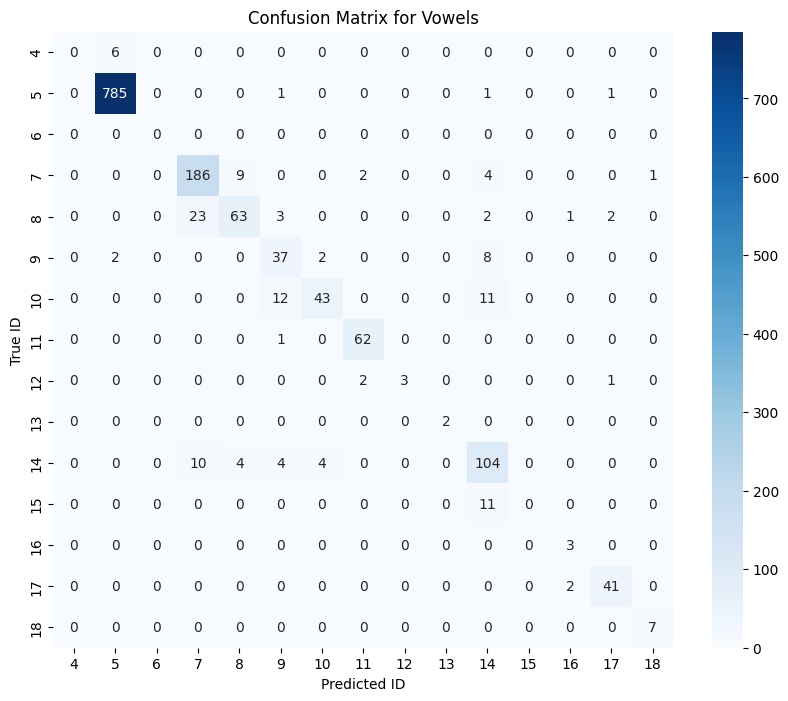

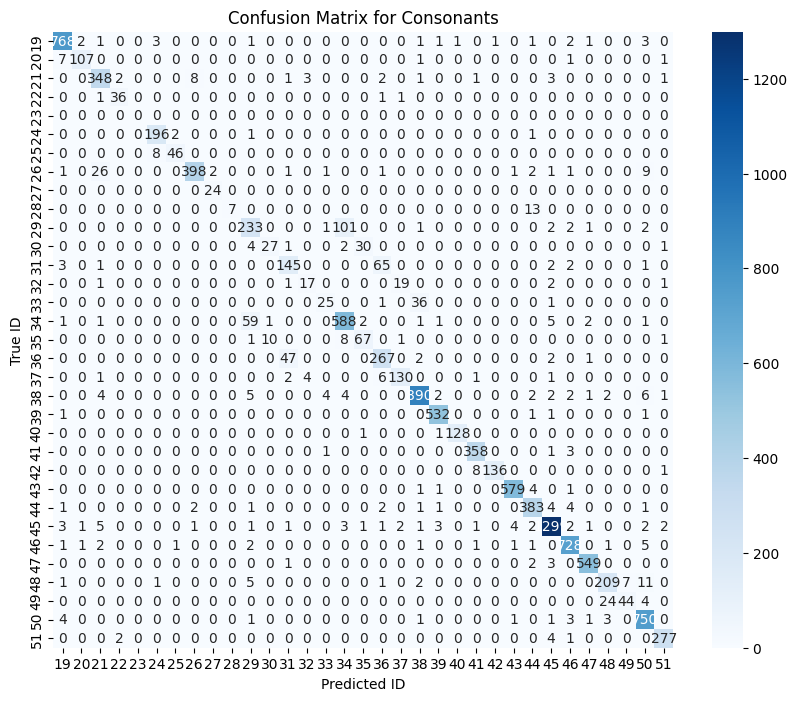

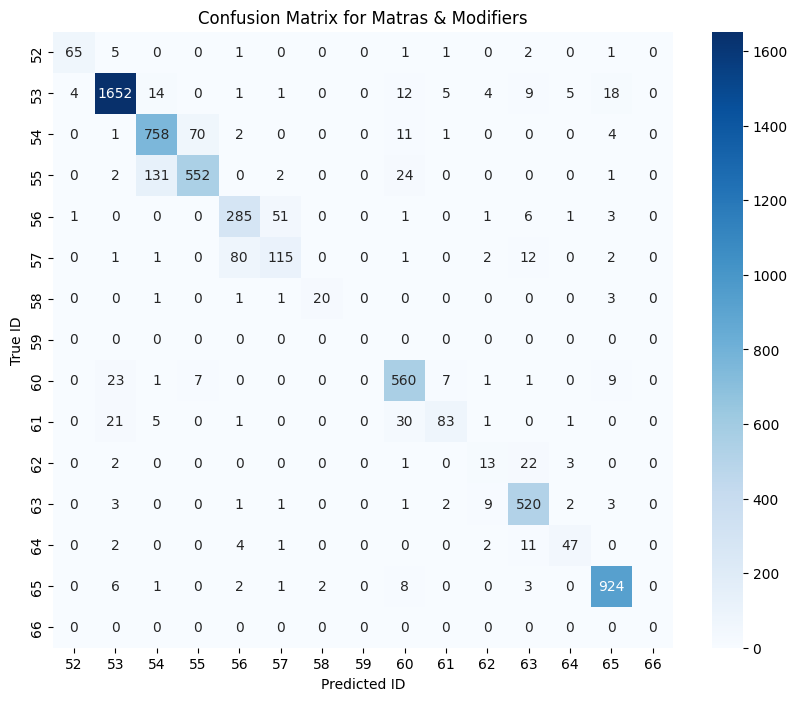

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Your id groups (already defined)
special_token_ids = [0, 1, 2, 3]  
vowel_ids = list(range(4, 19))   
consonant_ids = list(range(19, 52))  
matra_ids = list(range(52, 67))  

groups = {
    "Special Tokens": special_token_ids,
    "Vowels": vowel_ids,
    "Consonants": consonant_ids,
    "Matras & Modifiers": matra_ids,
}

# Function to filter y_true and y_pred by group of predicted IDs
def filter_by_pred_group(y_true, y_pred, group_ids):
    filtered_true = []
    filtered_pred = []
    for yt, yp in zip(y_true, y_pred):
        if yp in group_ids:
            filtered_true.append(yt)
            filtered_pred.append(yp)
    return filtered_true, filtered_pred

# Plot confusion matrix heatmap function
def plot_cm(y_true_group, y_pred_group, group_ids, group_name):
    # Compute confusion matrix
    cm = confusion_matrix(
        y_true_group, 
        y_pred_group, 
        labels=group_ids
    )
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=group_ids, yticklabels=group_ids)
    plt.title(f"Confusion Matrix for {group_name}")
    plt.xlabel("Predicted ID")
    plt.ylabel("True ID")
    plt.show()

# Loop over groups and plot
for group_name, group_ids in groups.items():
    y_true_group, y_pred_group = filter_by_pred_group(y_true, y_pred, group_ids)
    
    # If no data points for this group, skip plotting
    if len(y_true_group) == 0:
        print(f"No data to plot for group: {group_name}")
        continue
    
    plot_cm(y_true_group, y_pred_group, group_ids, group_name)